**Projet STA211 — Modélisation supervisée : Classification de publicités**

**Notebook 02 : Modélisation et Optimisation**

# Introduction

Ce notebook s'inscrit dans le cadre du cours **STA211** du CNAM et constitue la *phase de modélisation supervisée classique* du projet de classification de publicités sur internet.  
Il fait suite à l'analyse exploratoire et au pré-traitement réalisés dans `01_EDA_Preprocessing.ipynb`.

> **Chemins** : gérés via `modules.config.cfg.paths`.   
> **Reproductibilité** : `RANDOM_STATE = 42` fixé globalement.  
> **Dataset source** : [UCI Internet Ads](https://archive.ics.uci.edu/ml/datasets/Internet+Advertisements).

**Objectif**

Développer et optimiser des modèles classiques (Random Forest, SVM, XGBoost…) pour prédire la présence d'une publicité, en privilégiant le **F1-score** (classes déséquilibrées).

**Fichiers utilisés**

| Méthode d'imputation | Outliers inclus | Fichier utilisé                         | Emplacement                                                              |
|----------------------|------------------|------------------------------------------|---------------------------------------------------------------------------|
| MICE                 | Oui              | `df_final_for_modeling_mice_with_outliers.csv`   | `data/processed/final_data_for_modeling/`                 |
| MICE                 | Non              | `df_final_for_modeling_mice_no_outliers.csv`     | `data/processed/final_data_for_modeling/`                 |
| KNN                  | Oui              | `df_final_for_modeling_knn_with_outliers.csv`    | `data/processed/final_data_for_modeling/`                  |
| KNN                  | Non              | `df_final_for_modeling_knn_no_outliers.csv`      | `data/processed/final_data_for_modeling/`                  |

**Fichiers intermédiaires disponibles**

| Méthode d'imputation | Fichier utilisé                         | Emplacement                                                              |
|----------------------|------------------------------------------|---------------------------------------------------------------------------|
| MICE                 | `df_mice_imputed_gb.csv`                | `data/processed/`                                                        |
| KNN                  | `df_knn_imputed_k7.csv`                 | `data/processed/`                                                        |

<h2>📚 Table des matières</h2>

<ul>
  <li><a href="#0-préparation-de-l’environnement--bibliothèques">0. Préparation de l’environnement & bibliothèques</a></li>
  <li><a href="#1-chargement-des-données-imputées">1. Chargement des données prétraitées</a></li>
  <li><a href="#2-split-des-données-train--validation--test">2. Split des données (train — validation — test)</a></li>
  <li><a href="#3-pipelines-de-prétraitement--borderlinesmote">3. Pipelines de prétraitement + BorderlineSMOTE</a></li>
  <li><a href="#4-définition-des-modèles--grilles-d’hyperparamètres">4. Définition des modèles + grilles d’hyperparamètres</a></li>
  <li><a href="#5-sélection-de-variables">5 Sélection de variables</a></li>
  <li><a href="#6-évaluation-des-modèles">6. Évaluation des modèles</a>
   
  <li><a href="#7-optimisation-du-seuil-de-décision-f1">7. Optimisation du seuil de décision (F1)</a></li>
  <li><a href="#8-évaluation-finale-sur-le-jeu-de-test">8. Évaluation finale sur le jeu de test</a></li>
  <li><a href="#9-conclusion--transition-vers-le-stacking">9. Conclusion & transition vers le stacking</a></li>
</ul>


# 0. Préparation de l’environnement & bibliothèques <a id="0-préparation-de-l’environnement--bibliothèques"></a>

Cette section configure l'environnement d'exécution pour la **modélisation et optimisation des modèles classiques** dans le cadre du projet STA211.

Elle inclut :
- La détection de l'environnement (Google Colab ou local),
- Le montage de Google Drive pour Colab,
- L'installation des dépendances via `requirements.txt`,
- La configuration des chemins pour les données, modules, modèles, et figures,
- La configuration des options d'affichage de pandas,
- L'affichage des versions de pandas et IPython pour garantir la reproductibilité.


## 0.1 Paramètres et Imports

In [14]:
import sys, os, logging
from pathlib import Path

# ── 0. Logger clair (avec Rich si dispo)
try:
    from rich.logging import RichHandler
    logging.basicConfig(level="INFO",
                        format="%(message)s",
                        handlers=[RichHandler(rich_tracebacks=True, markup=True)],
                        force=True)
except ModuleNotFoundError:
    logging.basicConfig(level=logging.INFO,
                        format="%(asctime)s - %(levelname)s - %(message)s",
                        stream=sys.stdout,
                        force=True)
logger = logging.getLogger(__name__)

# ── 1. Détection environnement Colab
def _in_colab() -> bool:
    try: import google.colab
    except ImportError: return False
    else: return True

# ── 2. Montage Drive manuel rapide
if _in_colab():
    from google.colab import drive
    if not Path("/content/drive/MyDrive/Colab Notebooks").exists():
        logger.info("🔗 Montage de Google Drive en cours…")
        drive.mount("/content/drive", force_remount=False)

# ── 3. Localisation racine projet STA211
def find_project_root() -> Path:
    env_path = os.getenv("STA211_PROJECT_PATH")
    if env_path and (Path(env_path) / "modules").exists():
        return Path(env_path).expanduser().resolve()

    # Chemin Colab correct
    default_colab = Path("/content/drive/MyDrive/Colab Notebooks/projet_sta211_2025")
    if _in_colab() and (default_colab / "modules").exists():
        return default_colab.resolve()

    cwd = Path.cwd()
    for p in [cwd, *cwd.parents]:
        if (p / "modules").exists():
            return p.resolve()

    raise FileNotFoundError("❌ Impossible de localiser un dossier contenant 'modules/'.")

# ── 4. Définition racine + PYTHONPATH
ROOT_DIR = find_project_root()
os.environ["STA211_PROJECT_PATH"] = str(ROOT_DIR)
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
logger.info(f"📂 Racine projet détectée : {ROOT_DIR}")
logger.info(f"PYTHONPATH ← {ROOT_DIR}")

# ── 5. Initialisation de la configuration projet
from modules.config import cfg

# ✅ CORRECTION : Redéfinir les chemins avec la racine correcte
cfg.paths.ROOT_DIR = ROOT_DIR
cfg.paths.MODULE_DIR = ROOT_DIR / "modules"
cfg.paths.RAW_DATA_DIR = ROOT_DIR / "data" / "raw"
cfg.paths.DATA_PROCESSED = ROOT_DIR / "data" / "processed"
cfg.paths.OUTPUTS_DIR = ROOT_DIR / "outputs"
cfg.paths.FIGURES_NB2_DIR = ROOT_DIR / "outputs" / "figures" / "notebook2"
cfg.paths.THRESHOLDS_DIR = ROOT_DIR / "outputs" / "modeling" / "thresholds"
cfg.paths.MODELS_DIR = ROOT_DIR / "outputs"/ "modeling"

# ── 6. Affichage des chemins utiles
def display_paths(style: bool = True):
    import pandas as pd
    paths_dict = {
        "ROOT_DIR": cfg.paths.ROOT_DIR,
        "MODULE_DIR": cfg.paths.MODULE_DIR,
        "RAW_DATA_DIR": cfg.paths.RAW_DATA_DIR,
        "DATA_PROCESSED": cfg.paths.DATA_PROCESSED,
        "OUTPUTS_DIR": cfg.paths.OUTPUTS_DIR,
        "FIGURES_NB2_DIR": cfg.paths.FIGURES_NB2_DIR,
        "THRESHOLDS_DIR": cfg.paths.THRESHOLDS_DIR,
        "MODELS_DIR": cfg.paths.MODELS_DIR
    }
    rows = [{"Clé": k, "Chemin": str(v)} for k, v in paths_dict.items()]
    df = pd.DataFrame(rows).set_index("Clé")
    from IPython.display import display
    display(df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "left")]},
        {"selector": "td", "props": [("text-align", "left")]},
    ]) if style else df)

# ── 7. Variables principales de données
RAW_DATA_DIR          = cfg.paths.RAW_DATA_DIR
DATA_PROCESSED        = cfg.paths.DATA_PROCESSED
MODELS_DIR            = cfg.paths.MODELS_DIR
FIGURES_NB2_DIR       = cfg.paths.FIGURES_NB2_DIR
THRESHOLDS_DIR        = cfg.paths.THRESHOLDS_DIR
OUTPUTS_DIR           = cfg.paths.OUTPUTS_DIR

display_paths()

logger.info("✅ Initialisation complète réussie - Notebook 02 prêt !")

2025-08-13 01:37:23,150 - INFO - 📂 Racine projet détectée : C:\sta211-project
2025-08-13 01:37:23,151 - INFO - PYTHONPATH ← C:\sta211-project


,Chemin
Clé,
ROOT_DIR,C:\sta211-project
MODULE_DIR,C:\sta211-project\modules
RAW_DATA_DIR,C:\sta211-project\data\raw
DATA_PROCESSED,C:\sta211-project\data\processed
OUTPUTS_DIR,C:\sta211-project\outputs
FIGURES_NB2_DIR,C:\sta211-project\outputs\figures\notebook2
THRESHOLDS_DIR,C:\sta211-project\outputs\modeling\thresholds
MODELS_DIR,C:\sta211-project\outputs\modeling


2025-08-13 01:37:23,159 - INFO - ✅ Initialisation complète réussie - Notebook 02 prêt !


## 0.2 Chargement des bibliothèques

Cette section importe toutes les bibliothèques nécessaires à la **modélisation supervisée** via le module `imports_sta211.py`.  
Les bibliothèques incluent :

- Traitement des données : `pandas`, `numpy`
- Modélisation supervisée : `scikit-learn`, `xgboost`
- Traitement du déséquilibre : `imblearn`
- Visualisation des résultats : `matplotlib`, `seaborn`
- Utilitaires : `tqdm` pour le suivi, `joblib`, `json`

Les paramètres de visualisation (seaborn, matplotlib) ainsi que les options pandas sont préconfigurés dans `imports_sta211.py`.  
Un affichage des versions des bibliothèques principales est également effectué pour assurer la **reproductibilité**.


In [15]:
## 0.2 · Chargement des bibliothèques ──────────────────────────────────────────

from IPython.display import Markdown, display

# ⬇️ Imports directs des bibliothèques nécessaires
try:
    # Bibliothèques de base
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib
    import seaborn as sns

    # Scikit-learn et extensions
    import sklearn
    from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import (
        classification_report, confusion_matrix, roc_auc_score,
        precision_recall_curve, f1_score, precision_score, recall_score
    )

    # Imbalanced-learn pour le traitement du déséquilibre
    import imblearn
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline

    # XGBoost
    import xgboost as xgb
    from xgboost import XGBClassifier

    # Utilitaires
    import joblib
    import json
    import warnings
    from tqdm import tqdm
    import scipy

    # Configuration des warnings
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)

    logger.info("📚 Bibliothèques importées avec succès")

except ImportError as e:
    logger.error(f"❌ Erreur d'importation : {e}")
    raise

# ───────────────────────────────────────────────────────────────────────────
# ✅ Affichage des versions principales
# ───────────────────────────────────────────────────────────────────────────

def _safe_version(mod, fallback="—"):
    """Retourne mod.__version__ ou un fallback si le module est absent."""
    try:
        return mod.__version__
    except Exception:
        return fallback

def display_modeling_library_versions():
    mods = {
        "pandas"           : pd,
        "numpy"            : np,
        "scikit-learn"     : sklearn,
        "imbalanced-learn" : imblearn,
        "xgboost"          : xgb,
        "matplotlib"       : matplotlib,
        "seaborn"          : sns,
        "scipy"            : scipy,
        "joblib"           : joblib,
        "tqdm"             : __import__("tqdm"),
        "ipython"          : __import__("IPython")
    }
    versions_md = "\n".join(f"- `{k}` : {_safe_version(v)}" for k, v in mods.items())
    display(Markdown(f"✅ Versions des bibliothèques de modélisation\n{versions_md}"))

display_modeling_library_versions()
logger.info("✅ Chargement des bibliothèques terminé")

2025-08-13 01:37:31,403 - INFO - 📚 Bibliothèques importées avec succès


✅ Versions des bibliothèques de modélisation
- `pandas` : 2.2.2
- `numpy` : 2.0.2
- `scikit-learn` : 1.6.1
- `imbalanced-learn` : 0.13.0
- `xgboost` : 2.1.4
- `matplotlib` : 3.10.0
- `seaborn` : 0.13.2
- `scipy` : 1.15.3
- `joblib` : 1.5.1
- `tqdm` : 4.67.1
- `ipython` : 8.37.0

2025-08-13 01:37:31,407 - INFO - ✅ Chargement des bibliothèques terminé


# 1. Chargement des données traitées <a id="1-chargement-des-données-imputées"></a>

Dans cette cellule, on initialise le chargement des 4 versions finales des jeux de données, prétraitées selon deux critères :

- Méthode d’imputation : **KNN** ou **MICE** ;
- Conservation ou suppression des **outliers**.

Chaque dataset est chargé depuis un fichier `.parquet` et une vérification rapide affiche la distribution de la variable cible (`ad.` vs `noad.`).  
Une interface interactive permet de visualiser rapidement un aperçu de chaque jeu.

La fonction `load_dataset(name)` permet un chargement manuel et sera utilisée dans les étapes suivantes.


In [16]:
import gc
from pathlib import Path
from IPython.display import display, Markdown

try:
    import ipywidgets as wd
    WIDGETS_AVAILABLE = True
    print("✅ ipywidgets disponible - Interface interactive activée")
except ImportError:
    WIDGETS_AVAILABLE = False
    print("⚠️ ipywidgets non disponible - Mode standard activé")

try:
    from modules.config.project_config import CLASS_LABELS as LABEL_MAP
    print("✅ Mapping des classes importé")
except ImportError:
    LABEL_MAP = {0: "noad.", 1: "ad."}
    print("⚠️ Mapping par défaut appliqué")

# ✅ CORRECTION : Utiliser cfg.paths au lieu de paths
data_dir = cfg.paths.DATA_PROCESSED / "final_data_for_modeling"

expected_names = {
    "mice_no_outliers",
    "knn_no_outliers",
    "mice_with_outliers",
    "knn_with_outliers"
}

available_files = [f for f in data_dir.glob("df_final_for_modeling_*.csv")
                   if f.stem.replace("df_final_for_modeling_", "") in expected_names]

NAMES = [f.stem.replace("df_final_for_modeling_", "") for f in available_files]

print(f"\n📂 {len(NAMES)} datasets détectés : {NAMES}")

def _csv_path(name: str) -> Path:
    return data_dir / f"df_final_for_modeling_{name}.csv"

# Distribution cible renommée outcome
if NAMES:
    print("\n Distribution cible (outcome) dans chaque fichier")
    for n in NAMES:
        fp = _csv_path(n)
        try:
            df_temp = pd.read_csv(fp)
            s = df_temp["outcome"] if "outcome" in df_temp.columns else df_temp["y"]

            pct = s.map(LABEL_MAP).value_counts(normalize=True).mul(100).round(2)
            print(f"{n:<20} | ad.: {pct.get('ad.', 0):>5.1f}% | noad.: {pct.get('noad.', 0):>5.1f}%")
        except Exception as e:
            print(f"⚠️ Erreur lecture {fp.name} → {e}")
else:
    print("❌ Aucun dataset CSV trouvé dans :", data_dir)

def load_dataset(name: str) -> pd.DataFrame | None:
    fp = _csv_path(name)
    try:
        df = pd.read_csv(fp)
        if "y" in df.columns:
            df.rename(columns={"y": "outcome"}, inplace=True)
        print(f"✅ {name} chargé : {df.shape}")
        return df
    except Exception as e:
        print(f"❌ Erreur : {e}")
        return None

if NAMES:
    if WIDGETS_AVAILABLE:
        dropdown = wd.Dropdown(options=NAMES, value=NAMES[0], description="Dataset :")
        out = wd.Output()

        def _on_change(change):
            with out:
                out.clear_output()
                df = load_dataset(change["new"])
                if df is not None:
                    display(df.head())

        dropdown.observe(_on_change, names="value")
        display(Markdown(" Sélectionnez un dataset :"))
        display(dropdown, out)
    else:
        print("\n Mode standard :")
        for i, name in enumerate(NAMES, 1):
            print(f"   {i}. {name}")
        print(" Utilisez load_dataset('nom_du_dataset') pour charger un dataset")
else:
    print(" Aucune donnée à charger. Vérifiez les fichiers dans :", data_dir)

print("\n Nettoyage mémoire...")
gc.collect()
print("✅ Initialisation des datasets terminée !")

✅ ipywidgets disponible - Interface interactive activée
⚠️ Mapping par défaut appliqué

📂 4 datasets détectés : ['knn_no_outliers', 'knn_with_outliers', 'mice_no_outliers', 'mice_with_outliers']

 Distribution cible (outcome) dans chaque fichier
knn_no_outliers      | ad.:  14.0% | noad.:  86.0%
knn_with_outliers    | ad.:  14.0% | noad.:  86.0%
mice_no_outliers     | ad.:  14.0% | noad.:  86.0%
mice_with_outliers   | ad.:  14.0% | noad.:  86.0%


 Sélectionnez un dataset :

Dropdown(description='Dataset :', options=('knn_no_outliers', 'knn_with_outliers', 'mice_no_outliers', 'mice_w…

Output()


 Nettoyage mémoire...
✅ Initialisation des datasets terminée !


**Décision :** conservons les outliers et misons nous sur des algorithmes robustes  

| Dataset | Obs. | % Ads | Ads (n) | % Non-ads | Non-ads (n) |
|---------|-----:|------:|--------:|----------:|------------:|
| KNN **avec** outliers | **2 459** | **14 %** | 344 | 86 % | 2 115 |
| KNN **sans** outliers | 1 885 | 9 % | 175 | 91 % | 1 710 |
| Impact suppression | −23 % lignes | −4,7 pp | −49 % | +4,7 pp | −19 % |

- **49 %** des *ads* supprimés contre **19 %** des *non-ads*  
- Ratio minoritaire **14 % → 9 %**  
- F1 Random Forest : **0 .89 → 0 .80** (−10 %)

**Choix retenu**

* **✅ Garder** le dataset **with outliers**  
* Algorithmes **robustes** : Random Forest, XGBoost, SVM (RBF), Logistic Reg. régularisée  
* Pré-traitement : StandardScaler, log / Box-Cox, régularisation L1/L2  
* Seuils de validation : **F1 > 0 .85** ; rappel *ads* > 0 .80  

> Les outliers portent des signaux discriminants ; les supprimer pénalise la classe d’intérêt.  
> Mieux vaut s’adapter algorithmiquement que « nettoyer » agressivement.


In [17]:
print("\n Chargement des datasets principaux...")
print("─" * 55)

df_knn  = load_dataset("knn_no_outliers")
df_mice = load_dataset("mice_no_outliers")


 Chargement des datasets principaux...
───────────────────────────────────────────────────────
✅ knn_no_outliers chargé : (2459, 661)
✅ mice_no_outliers chargé : (2459, 661)


## 1.2 Répartition de la variable cible (ad. vs noad.)

Avant toute modélisation, il est essentiel d’examiner la distribution de la variable cible.

Cette visualisation met en évidence le **déséquilibre des classes** :
- Très peu d’images sont des publicités (`ad.`),
- La majorité sont des `noad.`

Cela justifie l’usage d’un **rééchantillonnage** (SMOTE) et d’une **optimisation du seuil**.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\sta211-project\\outputs\\figures\\notebook2\\target_distribution_knn-mice_comparison.png'

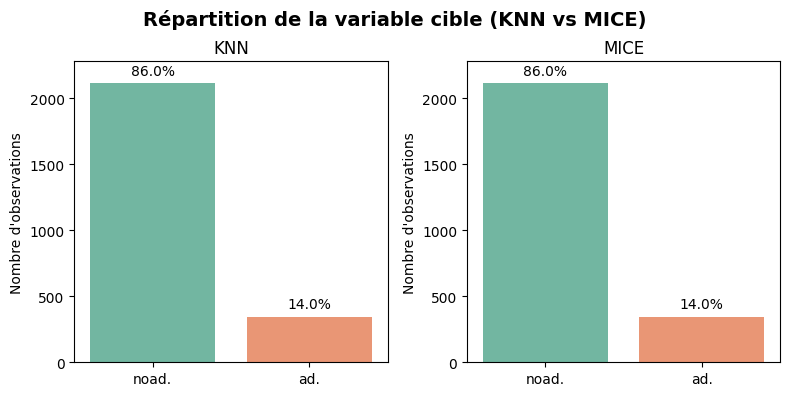

In [18]:
# ## Répartition de la variable cible (ad. vs noad.) — version courte

cats = ['noad.', 'ad.']
label_map = {0:'noad.', 1:'ad.', '0':'noad.', '1':'ad.', 'noad.':'noad.', 'ad.':'ad.'}

def prep(df):
    s = pd.Series(df['outcome']).map(label_map)
    return df.assign(outcome_label=pd.Categorical(s, categories=cats, ordered=True))

def add_perc(ax, total):
    if not ax.patches: return
    ymax = max(p.get_height() for p in ax.patches)
    ax.set_ylim(0, ymax * 1.08)
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height()+ymax*0.02,
                f'{100*p.get_height()/total:.1f}%', ha='center', va='bottom', fontsize=10)

dfs = {'KNN': prep(df_knn), 'MICE': prep(df_mice)}

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
for ax, (title, dfx) in zip(axes, dfs.items()):
    sns.countplot(data=dfx, x='outcome_label', order=cats, palette='Set2', ax=ax)
    ax.set_title(title); ax.set_xlabel(''); ax.set_ylabel('Nombre d\'observations')
    add_perc(ax, len(dfx))

fig.suptitle("Répartition de la variable cible (KNN vs MICE)", fontsize=14, fontweight='bold')
plt.tight_layout(); plt.subplots_adjust(top=0.85)

fig_path = FIGURES_NB2_DIR / "target_distribution_knn-mice_comparison.png"
fig.savefig(fig_path, dpi=150, bbox_inches='tight'); plt.show()

print("📊 Statistiques détaillées :\n" + "-"*50)
for name, dfx in dfs.items():
    vc = dfx['outcome_label'].value_counts(dropna=False)
    total = vc.sum(); ads = vc.get('ad.', 0); noads = vc.get('noad.', 0)
    print(f"{name:<20} | Total: {total:>4} | Ads: {ads:>3} ({ads/total:>5.1%}) | No-ads: {noads:>4} ({noads/total:>5.1%})")

logger.info(f"📊 Graphe comparatif sauvegardé → {fig_path.name}")


# 2. Split des données (train — validation — test) <a id="2-split-des-données-train--validation--test"></a>

| Étape | Détails |
|-------|---------|
| **Séparation cible / features** | `y = df["outcome"]` <br>`X = df.drop(columns=["outcome"])` |
| **Encodage cible** | 1 = `ad.` &nbsp;&nbsp;·&nbsp;&nbsp; 0 = `noad.` |
| **Split train / val / test** | `train_test_split(test_size=0.2, stratify=y, random_state=...)` pour créer un jeu **test** <br> puis un second `train_test_split` (ex: `test_size=0.25`) pour extraire la **validation** depuis le train initial |
| **Sauvegarde des colonnes** | `feature_cols = X_train.columns.tolist()` — utile pour le preprocessing et les prédictions finales |

> Nous répartissons les données en **60 % apprentissage**, **20 % validation**, et **20 % test**, tout en respectant le déséquilibre initial des classes (stratification).



> **Remarque**  
> - Le « jeu de test » mentionné ici correspond au **split interne** issu de `data_train.csv`. Il sert uniquement à évaluer nos modèles localement.  
> - Le véritable fichier **`data_test.csv`**, dépourvu de colonne cible, n’est utilisé qu’au moment de la **soumission finale** au challenge.


### Découpage des données en 3 ensembles : train, validation, test

Dans cette étape, nous réalisons un **split stratifié 60/20/20** des données :

- **60 %** pour l’apprentissage (`X_train`, `y_train`)  
- **20 %** pour la validation (`X_val`, `y_val`)  
- **20 %** pour le test final (`X_test`, `y_test`)

Le découpage se fait en deux temps :
1. Un premier `train_test_split` à 80/20 pour isoler le **jeu test** ;
2. Un second `train_test_split` à 75/25 sur le temporaire pour séparer **train** et **validation**.

On s’assure de la **stratification** par rapport à la variable cible `outcome` pour conserver la proportion d’annonces (classe minoritaire).  
Les résultats sont également **sérialisés** dans `MODEL_DIR` pour une réutilisation ultérieure (colonnes + jeux `train.pkl`, `val.pkl`, `test.pkl`).

Un résumé visuel est ensuite généré pour vérifier les répartitions des classes dans chaque ensemble.


In [13]:
# 2. Split des données (train — validation — test) <a id="2-split-des-données-train--validation--test"></a>
from sklearn.model_selection import train_test_split

log = logging.getLogger(__name__)
RANDOM_STATE = 42

TARGET = "outcome"                  # ← colonne cible unique

def tri_split_and_save(df: pd.DataFrame, name: str):
    """
    • Split stratifié 60 / 20 / 20  (train / val / test) – cible = TARGET
    • Sauvegarde columns + trois pickles dans le dossier spécifique (knn ou mice)
    • Retourne un dict des sous-ensembles
    """
    if TARGET not in df.columns:
        raise KeyError(f"La colonne cible « {TARGET} » est absente de {name}.")

    # Define the target directory based on the name (knn or mice)
    save_dir = MODELS_DIR / "notebook2" / name
    save_dir.mkdir(parents=True, exist_ok=True) # Create the directory if it doesn't exist

    X = df.drop(columns=[TARGET])
    y = df[TARGET].astype(int)

    # 80 / 20  ➜  temp / test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
    )
    # 75 / 25 du temp ➜ train / val  ⇒ 60 / 20 / 20 global
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
    )

    cols = X_train.columns.tolist()
    joblib.dump(cols,               save_dir / f"columns_{name}.pkl")
    joblib.dump({"X": X_train, "y": y_train}, save_dir / f"{name}_train.pkl")
    joblib.dump({"X": X_val,   "y": y_val},   save_dir / f"{name}_val.pkl")
    joblib.dump({"X": X_test,  "y": y_test},  save_dir / f"{name}_test.pkl")
    log.info(f"{name.upper():<4} | split 60/20/20 sauvegardé dans {save_dir} (cols = {len(cols)})")


    return dict(X_train=X_train, y_train=y_train,
                X_val=X_val,     y_val=y_val,
                X_test=X_test,   y_test=y_test)

# ── Création pour KNN & MICE ─────────────────────────────────────────────
splits = {
    "knn":  tri_split_and_save(df_knn,  "knn"),
    "mice": tri_split_and_save(df_mice, "mice"),
}

# ── Résumé visuel ────────────────────────────────────────────────────────
def split_summary(spl):
    lines = []
    for name, d in spl.items():
        lines.append(
            f"- **{name.upper()}** : "
            f"train {d['X_train'].shape} (ads {d['y_train'].mean():.2%}) · "
            f"val {d['X_val'].shape} (ads {d['y_val'].mean():.2%}) · "
            f"test {d['X_test'].shape} (ads {d['y_test'].mean():.2%})"
        )
    display(Markdown(" Découpage 60 / 20 / 20 (cible = outcome)\n" + "\n".join(lines)))

split_summary(splits)

2025-08-12 14:55:21,005 - INFO - KNN  | split 60/20/20 sauvegardé dans C:\sta211-project\outputs\modeling\notebook2\knn (cols = 660)
2025-08-12 14:55:21,079 - INFO - MICE | split 60/20/20 sauvegardé dans C:\sta211-project\outputs\modeling\notebook2\mice (cols = 660)


 Découpage 60 / 20 / 20 (cible = outcome)
- **KNN** : train (1475, 660) (ads 13.97%) · val (492, 660) (ads 14.02%) · test (492, 660) (ads 14.02%)
- **MICE** : train (1475, 660) (ads 13.97%) · val (492, 660) (ads 14.02%) · test (492, 660) (ads 14.02%)

In [14]:
# --- Sauvegarde de l'imputeur par la médiane pour la colonne X4 ---

print(" Sauvegarde de la médiane pour l'imputation de X4...")


models_dir = MODELS_DIR / "notebook2"
models_dir.mkdir(parents=True, exist_ok=True) # Crée le dossier s'il n'existe pas

try:
    if "X4" not in splits['mice']['X_train']:
        raise KeyError("Colonne 'X4' absente de X_train.")


    median_x4_train = splits['mice']['X_train']['X4'].median()

    # 2. Définir le chemin de sauvegarde
    save_path = models_dir / "median_imputer_X4.pkl"

    # 3. Sauvegarder la valeur de la médiane avec joblib
    joblib.dump(median_x4_train, save_path)

    print(f"✅ Médiane de X4 ({median_x4_train:.4f}) sauvegardée dans : {save_path}")

except KeyError:
    print("❌ ERREUR : La colonne 'X4' n'a pas été trouvée dans le jeu d'entraînement.")
except Exception as e:
    print(f"❌ Une erreur inattendue est survenue : {e}")

 Sauvegarde de la médiane pour l'imputation de X4...
✅ Médiane de X4 (1.0000) sauvegardée dans : C:\sta211-project\outputs\modeling\notebook2\median_imputer_X4.pkl


# 3. Pipelines de prétraitement + BorderlineSMOTE <a id="3-pipelines-de-prétraitement--borderlinesmote"></a>

## Étapes du pipeline

Pour préparer les données à la modélisation supervisée, nous construisons un pipeline modulaire combinant deux étapes clés :

- **Standardisation** des variables numériques avec `StandardScaler`, afin d’homogénéiser les échelles et éviter que certaines variables ne dominent les modèles sensibles à la magnitude (SVM, rég. log, etc.).
- **Équilibrage des classes** via `BorderlineSMOTE`, une version plus robuste de SMOTE qui génère des exemples synthétiques *en bordure* des zones de séparation, là où la classification est la plus difficile.

Le pipeline est appliqué **séparément** aux datasets issus des imputations **KNN** et **MICE**.

> La classe minoritaire `ad.` est artificiellement augmentée à **80 % de la classe `noad.`**, grâce à `sampling_strategy = 0.8`.  
> L'équilibrage est effectué **après standardisation** et **uniquement sur les données d'entraînement**, pour éviter toute fuite.

## Encapsulation dans `ImbPipeline`

On encapsule le tout dans un pipeline `ImbPipeline` (`imblearn.pipeline.Pipeline`) pour garantir :

- La **répétabilité** du traitement sur n’importe quel jeu (`train`, `val`, `test`) ;
- La **séparation stricte** entre transformation des données et apprentissage des modèles.

---

## Objectifs pédagogiques

- Obtenir des données **centrées-réduites** prêtes pour les modèles classiques (SVM, gradient Boosting, etc.) ;
- Générer des exemples synthétiques **autour des zones complexes** (bordures) pour enrichir l’apprentissage ;
- Conserver une distribution **réaliste et maîtrisée** tout en corrigeant le déséquilibre.

Les effets du pipeline sont résumés dans les cellules suivantes, notamment la **répartition actualisée des classes** après application.


## Construction du pipeline

Nous définissons ici une fonction `make_pipeline()` qui assemble un pipeline complet pour la classification :

- **Standardisation**,
- **Suréchantillonnage avec BorderlineSMOTE**,
- **Modèle de classification** (fourni en argument).

Cette structure garantit une chaîne de traitement stable, compatible avec la validation croisée, sans fuite de données.


In [15]:
## Pipeline unifié (imputation de sécurité) + scale + BorderlineSMOTE + modèle)

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.preprocessing import StandardScaler

def make_pipeline(model, sampling_ratio=0.8):
    """
    Pipeline complet :
      StandardScaler ➜ BorderlineSMOTE ➜ modèle
    """
    return Pipeline(steps=[
        ("scale",  StandardScaler(with_mean=False)),
        ("smote",  BorderlineSMOTE(
            sampling_strategy=sampling_ratio,
            random_state=RANDOM_STATE,
            kind="borderline-1")),
        ("clf",    model),
    ])


**Pourquoi `sampling_strategy = 0.8` pour Borderline-SMOTE ?**

| Option | Distribution finale | Avantages | Risques |
|--------|-------------------|-----------|---------|
| `'auto'` (50/50) | 14% → **50%** (x3.6) | Rappel maximal | Sur-apprentissage fort |
| **`0.8`** (choix) | 14% → **44%** (x2.9) | **Compromis optimal** | Risque contrôlé |
| `0.5` | 14% → **33%** (x1.8) | Conservateur | Déséquilibre résiduel |

**Contexte :** KNN et MICE avec outliers (14% ads / 86% no-ads)

**Impact sur l'entraînement :** 206 ads → 1015 ads (+809 synthétiques)

**Configuration retenue :**
```python
BorderlineSMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE, kind="borderline-1")
```

> **Objectif :** Équilibrage significatif (14% → 44%) pour maximiser F1-score sans sur-équilibrage.

** Évaluation comparative des modèles**

Nous comparons plusieurs algorithmes de classification binaire (**GBC, RF, SVM, MLP, XGBoost…**).  
Chaque modèle est encapsulé dans un **pipeline unique** :



**Jeux testés**

| Imputation | Entraînement | Évaluation |
|------------|-------------|------------|
| **KNN**  | `X_train_knn`, `y_train_knn` | `X_val_knn`, `y_val_knn` |
| **MICE** | `X_train_mice`, `y_train_mice` | `X_val_mice`, `y_val_mice` |

**Métriques suivies**
* **F1-score** (prioritaire, classes déséquilibrées)  
* Rappel & Précision  
* AUC ROC
* **Gap CV/validation** (détection surapprentissage)

**Objectifs**
1. Mesurer l'impact KNN vs MICE sur les performances.  
2. Quantifier le gain apporté par Borderline-SMOTE (sampling_strategy=0.8).  
3. Sélectionner le **meilleur modèle + imputation** selon le F1, sans négliger rappel/précision.

> **Note** : Le pipeline (StandardScaler → BorderlineSMOTE → Modèle) garantit **zéro fuite de données**. Le jeu de TEST reste protégé pour l'évaluation finale.

### Définition des grilles d'hyperparamètres & fonction d'évaluation renforcée

Dans cette section, nous définissons une **stratégie d'optimisation anti-overfitting** des modèles :

**Objectif principal**

> **Réduire l'écart entre score CV et validation**  
> (ex. : passer d'un gap de 0.06 à < 0.03 pour une excellente généralisation)

---

** Étapes techniques**

1. **Définition de grilles spécifiques** pour chaque modèle  
   → Plus **conservatrices**, **régularisées**, moins profondes / moins d'arbres / moins de paramètres extrêmes.

2. **Modèles concernés** :  
   - GradientBoosting, Random Forest  
   - SVM, MLP, XGBoost

3. **Ensemble des grilles stockées** dans `hyperparam_grids.json`.

4. **Validation croisée renforcée** :  
   - `StratifiedKFold(n_splits=10)` (10-fold systématique)
   - Préservation de la distribution des classes dans chaque fold

5. **Fonction `evaluate_model()` personnalisée** :  
   - Utilise `GridSearchCV` sur **TRAIN** avec CV 10-fold
   - Évalue les performances sur **VALIDATION**
   - Calcule l'écart de généralisation : `gap = F1_CV - F1_VAL`  
   - Détecte les cas d'overfitting via seuils sur `gap`

---

Cette structure permet de **sélectionner chaque modèle de façon équitable et robuste**, tout en conservant une traçabilité complète des hyperparamètres et performances. Le jeu de **TEST reste protégé** pour l'évaluation finale.

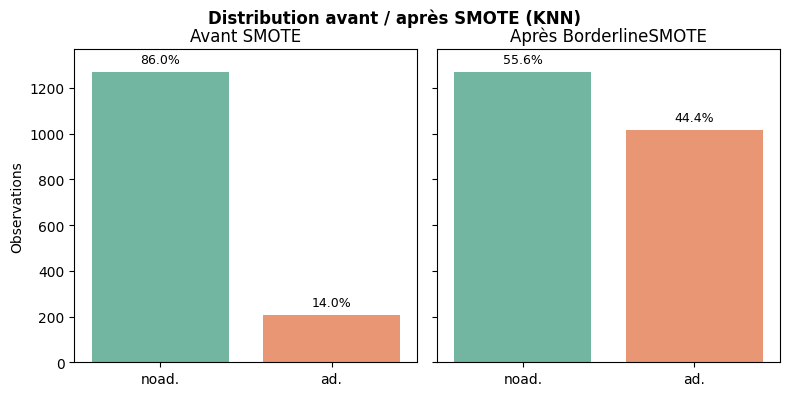

📊 Avant SMOTE : {'noad.': np.int64(1269), 'ad.': np.int64(206)}
📊 Après SMOTE : {'noad.': np.int64(1269), 'ad.': np.int64(1015)}
2025-08-12 14:50:00,910 - INFO - 📊 Graphe SMOTE sauvegardé → smote_effect_knn.png


In [ ]:
from imblearn.pipeline import Pipeline 

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import BorderlineSMOTE

# Catégories et mapping
cats = ['noad.', 'ad.']
label_map = {0:'noad.', 1:'ad.', '0':'noad.', '1':'ad.', 'noad.':'noad.', 'ad.':'ad.'}

def to_cat_y(y):
    s = pd.Series(y, name='y').map(label_map)
    return pd.Categorical(s, categories=cats, ordered=True)

def add_perc(ax, total):
    if not ax.patches: return
    ymax = max(p.get_height() for p in ax.patches)
    ax.set_ylim(0, ymax * 1.08)
    for p in ax.patches:
        ax.text(p.get_x()+p.get_width()/2, p.get_height()+ymax*0.02,
                f'{100*p.get_height()/total:.1f}%', ha='center', va='bottom', fontsize=9)

# Données brutes
X_raw = splits["knn"]["X_train"]
y_raw = splits["knn"]["y_train"]

# Avant SMOTE
y_before = to_cat_y(y_raw)

# Pipeline + BorderlineSMOTE
pipe = Pipeline([
    ("imp",   SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=False)),
    ("smote", BorderlineSMOTE(sampling_strategy=0.8, random_state=RANDOM_STATE))
])
X_res, y_res = pipe.fit_resample(X_raw, y_raw)

# Après SMOTE
y_after = to_cat_y(y_res)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
sns.countplot(x=y_before, order=cats, palette="Set2", ax=axes[0])
axes[0].set_title("Avant SMOTE"); axes[0].set_xlabel(""); axes[0].set_ylabel("Observations")
add_perc(axes[0], len(y_before))

sns.countplot(x=y_after, order=cats, palette="Set2", ax=axes[1])
axes[1].set_title("Après BorderlineSMOTE"); axes[1].set_xlabel(""); axes[1].set_ylabel("")
add_perc(axes[1], len(y_after))

fig.suptitle("Distribution avant / après SMOTE (KNN)", fontsize=12, fontweight="bold")
plt.tight_layout(); plt.subplots_adjust(top=0.88)

fig_path = FIGURES_NB2_DIR / "smote_effect_knn.png"
fig.savefig(fig_path, dpi=150, bbox_inches="tight"); plt.show()

# Stats rapides
print("📊 Avant SMOTE :", dict(pd.Series(y_before).value_counts()))
print("📊 Après SMOTE :", dict(pd.Series(y_after).value_counts()))

logger.info(f"📊 Graphe SMOTE sauvegardé → {fig_path.name}")


# 4. Définition des modèles + grilles d’hyperparamètres <a id="4-définition-des-modèles--grilles-d’hyperparamètres"></a>

In [16]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import json, logging

log = logging.getLogger(__name__)
RANDOM_STATE = 42

In [17]:
# === GRILLES ANTI-OVERFITTING ===
# Objectif : Réduire l'écart validation/test (0.9394 → 0.88)

# 1. Gradient Boosting
gradboost_params = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.05, 0.1],
    "clf__min_samples_split": [10, 20],
    "clf__min_samples_leaf": [5, 10],
    "clf__subsample": [0.7, 0.8]
}

# 2. Random Forest - BEAUCOUP PLUS CONSERVATEUR
rf_params = {
    "clf__n_estimators": [50, 100, 200],    # Moins d'arbres
    "clf__max_depth": [5, 10, 15],          # Profondeur limitée (vs None)
    "clf__min_samples_split": [10, 20],     # Plus strict (vs 2)
    "clf__min_samples_leaf": [5, 10],       # Feuilles plus grosses (vs 1)
    "clf__max_features": ["sqrt", "log2"],   # Retrait "None" qui overfitte
}

# 3. SVM - Plus de régularisation
svc_params = {
    "clf__C": [0.1, 1, 10],                # Moins de valeurs extrêmes
    "clf__kernel": ["rbf", "linear"],       # Retrait poly (complexe)
    "clf__gamma": ["scale", "auto"],        # Retrait valeurs numériques
}

# 4. MLP - Architectures plus simples
mlp_params = {
    "clf__hidden_layer_sizes": [(50,), (100,)],  # Plus simple
    "clf__activation": ["relu", "tanh"],          # Retrait logistic
    "clf__alpha": [1e-3, 1e-2, 1e-1],           # Plus de régularisation
    "clf__learning_rate": ["constant", "adaptive"],
    "clf__solver": ["adam"],                      # Plus stable que sgd
}

# 5. XGBoost - Régularisation renforcée
xgb_params = {
    "clf__n_estimators": [50, 100, 200],        #  Moins d'arbres
    "clf__max_depth": [3, 4, 5],                # Moins profond (vs 8)
    "clf__learning_rate": [0.05, 0.1, 0.15],    # Plus conservateur
    "clf__subsample": [0.7, 0.8],               # Sous-échantillonnage
    "clf__colsample_bytree": [0.7, 0.8],        # Idem pour features
    "clf__reg_lambda": [1, 5, 10],              # 🔧 Plus de régularisation L2
    "clf__reg_alpha": [0, 1, 5],                # Ajout régularisation L1
    "clf__scale_pos_weight": [1, 5, 10],        # Pour déséquilibre
}

# Dictionnaire mis à jour (sans Decision Tree et KNN)
param_grids = {
    "GradBoost": gradboost_params,
    "RandForest": rf_params,
    "SVM": svc_params,
    "MLP": mlp_params,
    "XGBoost": xgb_params,
}

# Sauvegarde pour référence
with open(MODELS_DIR / "hyperparam_grids.json", "w") as f:
    json.dump(param_grids, f, indent=2)
log.info("✅ Grilles d'hyper-paramètres anti-overfitting sauvegardées dans MODELS_DIR")

2025-08-12 14:56:31,551 - INFO - ✅ Grilles d'hyper-paramètres anti-overfitting sauvegardées dans MODELS_DIR


In [18]:
# dictionnaire des modèles de base (sans class_weight : SMOTE s'en charge)
models = {
    "GradBoost": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "RandForest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    "SVM": SVC(probability=True, random_state=RANDOM_STATE),
    "MLP": MLPClassifier(max_iter=500, random_state=RANDOM_STATE),
    "XGBoost": xgb.XGBClassifier(
        use_label_encoder=False, eval_metric="logloss",
        random_state=RANDOM_STATE, n_jobs=-1),
}

# 5. Sélection de variables par RFECV <a id="5-selection-variables"></a>


✅ Sélection terminée : 38 variables sélectionnées
🔝 Top 10 : ['X4', 'X188', 'X352', 'X358', 'X399', 'X419', 'X659', 'X969', 'X1012', 'X1020']


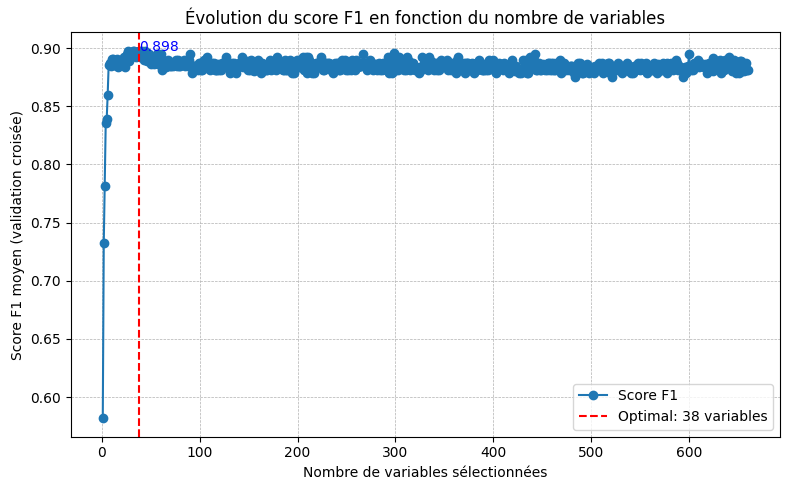

In [19]:
### ======= Pour les données KNN

# Données
X = splits["knn"]["X_train"]
y = splits["knn"]["y_train"]

# 🔍 RFECV
estimator = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=estimator, step=1, cv=cv, scoring='f1', n_jobs=-1, verbose=0)
selector.fit(X, y)

# Résultats
mask = selector.support_
selected_features = X.columns[mask].tolist()

# Sauvegarde
rfecv_dir = MODELS_DIR / "notebook2" / "knn"
rfecv_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(selector, rfecv_dir / "rfecv_selector_knn.pkl")
joblib.dump(selected_features, rfecv_dir / "selected_features_knn.pkl")

print(f"✅ Sélection terminée : {len(selected_features)} variables sélectionnées")
print("🔝 Top 10 :", selected_features[:10])


# 📈 Affichage du score F1 par nombre de variables
scores = selector.cv_results_["mean_test_score"]


optimal_num_features = selector.n_features_
optimal_score = max(scores)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(scores) + 1), scores, marker='o', label='Score F1')
plt.axvline(optimal_num_features, color='red', linestyle='--', label=f'Optimal: {optimal_num_features} variables')
plt.scatter(optimal_num_features, optimal_score, color='red')
plt.text(optimal_num_features + 0.5, optimal_score, f'{optimal_score:.3f}', color='blue')
plt.xlabel("Nombre de variables sélectionnées")
plt.ylabel("Score F1 moyen (validation croisée)")
plt.title("Évolution du score F1 en fonction du nombre de variables")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [20]:
# Charger les variables sélectionnées (par RFECV sur KNN)
selected_features_knn = joblib.load(rfecv_dir / "rfecv_selector_knn.pkl").get_feature_names_out()

# Dossier de sauvegarde
reduced_dir = MODELS_DIR / "notebook2" / "knn" / "reduced"
reduced_dir.mkdir(parents=True, exist_ok=True)

# Dictionnaire des splits KNN
splits_knn = splits["knn"]

# Sauvegarde des jeux de données réduits
for subset_name in ["train", "val", "test"]:
    X_subset = splits_knn[f"X_{subset_name}"][selected_features_knn]
    y_subset = splits_knn[f"y_{subset_name}"]

    joblib.dump({"X": X_subset, "y": y_subset}, reduced_dir / f"knn_{subset_name}_reduced.pkl")
    print(f"✅ {subset_name.capitalize()} réduit sauvegardé : {reduced_dir.name}/knn_{subset_name}_reduced.pkl")

# Sauvegarde des noms de variables sélectionnées
joblib.dump(list(selected_features_knn), reduced_dir / "selected_columns_knn.pkl")
print(f"\n✅ Variables sélectionnées sauvegardées : {reduced_dir/'selected_columns_knn.pkl'}")


✅ Train réduit sauvegardé : reduced/knn_train_reduced.pkl
✅ Val réduit sauvegardé : reduced/knn_val_reduced.pkl
✅ Test réduit sauvegardé : reduced/knn_test_reduced.pkl

✅ Variables sélectionnées sauvegardées : C:\sta211-project\outputs\modeling\notebook2\knn\reduced\selected_columns_knn.pkl


In [21]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import joblib

# Données MICE
X = splits["mice"]["X_train"]
y = splits["mice"]["y_train"]

# Estimateur Gradient Boosting avec hyperparamètres stables
estimator = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,
    random_state=42
)

# RFECV sans affichage répétitif
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=estimator, step=1, cv=cv, scoring='f1', n_jobs=-1, verbose=0)
selector.fit(X, y)

# Résultats
mask = selector.support_
selected_features = X.columns[mask].tolist()

# Sauvegarde
rfecv_dir = MODELS_DIR / "notebook2" / "mice"
rfecv_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(selector, rfecv_dir / "rfecv_selector_mice.pkl")
joblib.dump(selected_features, rfecv_dir / "selected_features_mice.pkl")

# Résumé
print(f"✅ Sélection terminée : {len(selected_features)} variables sélectionnées")
print("🔝 Top 10 :", selected_features[:10])


✅ Sélection terminée : 25 variables sélectionnées
🔝 Top 10 : ['X352', 'X358', 'X399', 'X419', 'X659', 'X969', 'X1023', 'X1082', 'X1110', 'X1230']


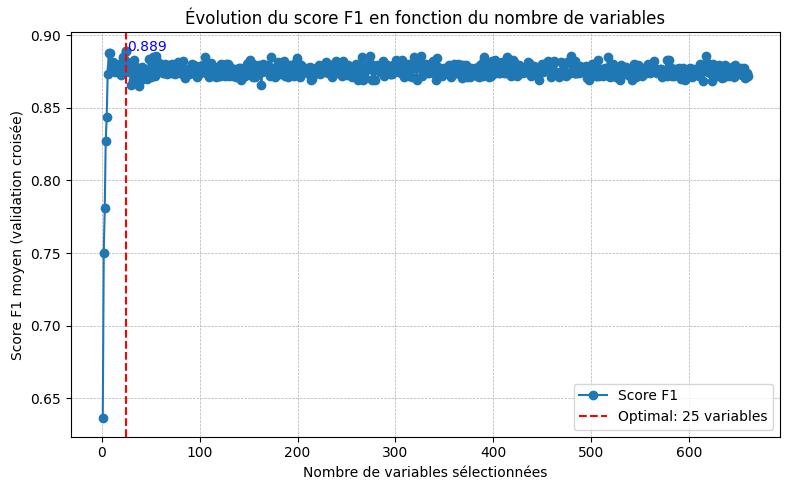

In [22]:
scores = selector.cv_results_["mean_test_score"]
optimal_num_features = selector.n_features_
optimal_score = max(scores)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(scores) + 1), scores, marker='o', label='Score F1')
plt.axvline(optimal_num_features, color='red', linestyle='--', label=f'Optimal: {optimal_num_features} variables')
plt.scatter(optimal_num_features, optimal_score, color='red')
plt.text(optimal_num_features + 0.5, optimal_score, f'{optimal_score:.3f}', color='blue')
plt.xlabel("Nombre de variables sélectionnées")
plt.ylabel("Score F1 moyen (validation croisée)")
plt.title("Évolution du score F1 en fonction du nombre de variables")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [23]:
# Charger les variables sélectionnées par RFECV (MICE)
rfecv_dir_mice = MODELS_DIR / "notebook2" / "mice"
selected_features_mice = joblib.load(rfecv_dir_mice / "rfecv_selector_mice.pkl").get_feature_names_out()

# 📁 Dossier de sauvegarde pour jeux réduits
reduced_dir_mice = rfecv_dir_mice / "reduced"
reduced_dir_mice.mkdir(parents=True, exist_ok=True)

# 📦 Dictionnaire des splits MICE
splits_mice = splits["mice"]

# 💾 Sauvegarde des jeux de données réduits
for subset_name in ["train", "val", "test"]:
    X_subset = splits_mice[f"X_{subset_name}"][selected_features_mice]
    y_subset = splits_mice[f"y_{subset_name}"]

    joblib.dump({"X": X_subset, "y": y_subset}, reduced_dir_mice / f"mice_{subset_name}_reduced.pkl")
    print(f"✅ {subset_name.capitalize()} réduit sauvegardé : {reduced_dir_mice.name}/mice_{subset_name}_reduced.pkl")

# 📄 Sauvegarde des noms de variables sélectionnées
joblib.dump(list(selected_features_mice), reduced_dir_mice / "selected_columns_mice.pkl")
print(f"\n✅ Variables sélectionnées sauvegardées : {reduced_dir_mice/'selected_columns_mice.pkl'}")


✅ Train réduit sauvegardé : reduced/mice_train_reduced.pkl
✅ Val réduit sauvegardé : reduced/mice_val_reduced.pkl
✅ Test réduit sauvegardé : reduced/mice_test_reduced.pkl

✅ Variables sélectionnées sauvegardées : C:\sta211-project\outputs\modeling\notebook2\mice\reduced\selected_columns_mice.pkl


# 6. Évaluation des modèles <a id="5-évaluation-des-modèles"></a>

## Fonction d’évaluation et de sélection des modèles

Cette fonction `evaluate_model()` encapsule une procédure complète d’évaluation avec les objectifs suivants :

### Étapes de l’évaluation

- Utilisation de `GridSearchCV` pour rechercher les meilleurs hyperparamètres via une validation croisée **stratifiée à 5 plis** (possibilité de passer à 10 plis).
- Entraînement d’un **pipeline complet** (prétraitement + suréchantillonnage + modèle).
- Évaluation des performances sur :
  - **validation croisée** (`F1_CV`)
  - **test final** (`F1_test`)
- Comparaison des deux via un indicateur d’**overfitting** : `gap = F1_CV - F1_test`

### Métriques enregistrées

- F1-score binaire (priorité à la classe `ad.`)
- F1-score pondéré (tenue compte du déséquilibre)
- AUC (si `predict_proba` disponible)
- Précision / rappel
- Matrice de confusion

### Objectifs

- Identifier le meilleur modèle pour chaque jeu de données (`knn`, `mice`),
- **Minimiser le sur-apprentissage** tout en maintenant un F1 élevé,
- Sauvegarder tous les résultats dans `MODELS_DIR` pour les étapes suivantes (stacking, explicabilité, soumission...).


In [24]:
# === VALIDATION CROISÉE RENFORCÉE + FONCTIONS D'ÉVALUATION ===
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
)

log = logging.getLogger(__name__)

#Validation croisée renforcée (10-fold au lieu de 5)
CV = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# 🔧 Suppression des warnings XGBoost
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# === OBJECTIF CIBLE ===
# Réduire le gap validation/test de 0.06 à < 0.02
# Score test cible : > 0.90 (au lieu de 0.88)

# ──────────────────────────────────────────────────────────────────────────
def _plot_cm_with_metrics(y_true, y_pred, y_proba,
                          title="Confusion Matrix", plot=True) -> dict:
    """Affiche (optionnel) une matrice compacte + métriques, retourne les scores."""
    f1_bin = f1_score(y_true, y_pred, zero_division=0)
    prec   = precision_score(y_true, y_pred, zero_division=0)
    rec    = recall_score(y_true, y_pred, zero_division=0)
    auc    = roc_auc_score(y_true, y_proba) if y_proba is not None else None

    if plot:
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        subtitle = f"F1={f1_bin:.3f} · P={prec:.3f} · R={rec:.3f}"
        if auc is not None:
            subtitle += f" · AUC={auc:.3f}"
        plt.title(f"{title}\n{subtitle}", pad=20)
        plt.xlabel("Prédit"); plt.ylabel("Réel")
        plt.tight_layout(); plt.show()

    return dict(f1_binary=f1_bin, precision=prec, recall=rec, auc=auc)

# ──────────────────────────────────────────────────────────────────────────
def evaluate_model(name: str, base_model, param_grid: dict,
                   X_train, y_train, X_val, y_val, dataset: str,
                   plot_cm: bool = True):
    """
    GridSearchCV → meilleur pipeline.

    Paramètres:
    -----------
    X_train, y_train : Données d'entraînement (60%) pour GridSearchCV
    X_val, y_val     : Données de validation (20%) pour évaluation finale

    Retourne:
    ---------
    (pipeline, métriques) avec surveillance de l'overfitting
    """
    pipe = make_pipeline(base_model)
    gs   = GridSearchCV(pipe, param_grid, scoring="f1",
                        cv=CV, n_jobs=-1, verbose=0).fit(X_train, y_train)

    best   = gs.best_estimator_
    y_pred = best.predict(X_val)
    y_prob = best.predict_proba(X_val)[:, 1] if hasattr(best, "predict_proba") else None

    metrics = _plot_cm_with_metrics(
        y_val, y_pred, y_prob,
        title=f"{name} ({dataset})", plot=plot_cm
    )

    # 🔧 Calcul de l'écart CV/validation pour surveiller l'overfitting
    f1_cv = gs.best_score_          # Score moyen de la validation croisée
    f1_val = metrics["f1_binary"]   # Score sur le jeu de validation
    gap = f1_cv - f1_val

    metrics.update({
        "model": name,
        "dataset": dataset,
        "f1_weighted": f1_score(y_val, y_pred, average="weighted"),
        "best_params": gs.best_params_,
        "f1_cv": round(f1_cv, 4),      # Score validation croisée
        "f1_val": round(f1_val, 4),    # Score validation finale
        "gap": round(gap, 4),          # Écart CV/validation (indicateur overfitting)
    })

    # 🔧 Affichage enrichi avec surveillance de l'overfitting
    print(f"📊 {name} ({dataset}): F1_CV={f1_cv:.3f}, F1_VAL={f1_val:.3f}, Gap={gap:.3f}")
    if gap > 0.05:
        print(f"⚠️  Overfitting détecté (gap > 0.05)")
    elif gap > 0.03:
        print(f"🔶 Léger overfitting (gap > 0.03)")
    else:
        print(f"✅ Bonne généralisation (gap ≤ 0.03)")

    # ⬇️ Sauvegardes
    joblib.dump(best, MODELS_DIR / f"best_{name.lower()}_{dataset}.joblib")
    with open(MODELS_DIR / f"best_params_{name.lower()}_{dataset}.json", "w") as f:
        json.dump(gs.best_params_, f, indent=2)

    return best, metrics

# ──────────────────────────────────────────────────────────────────────────
def evaluate_all(models_dict, grids_dict,
                 X_train, y_train, X_val, y_val, dataset: str,
                 plot_cm: bool = True) -> tuple[pd.DataFrame, dict]:
    """
    Boucle d'évaluation sur tous les modèles.

    Paramètres:
    -----------
    X_train, y_train : Données d'entraînement (60%)
    X_val, y_val     : Données de validation (20%)

    Retourne:
    ---------
    (DataFrame des résultats, dict des meilleurs pipelines)
    """
    records, best_pipelines = [], {}

    print(f" Évaluation sur {dataset.upper()} avec CV={CV.n_splits}-fold")
    print("=" * 60)
    print(" TRAIN → VAL (sélection des modèles)")
    print("-" * 60)

    for name, base_model in models_dict.items():
        print(f" {name} ({dataset})")
        best, rec = evaluate_model(
            name, base_model, grids_dict[name],
            X_train, y_train, X_val, y_val, dataset,
            plot_cm=plot_cm
        )
        records.append(rec); best_pipelines[name] = best

    df = (pd.DataFrame(records)
            .sort_values("f1_val", ascending=False)  # Tri par F1 validation
            .reset_index(drop=True))

    # Affichage enrichi avec métriques d'overfitting
    fmt = {c: "{:.4f}" for c in ["f1_val", "precision", "recall", "auc", "f1_cv", "gap"] if c in df}
    display(df.style.format(fmt, na_rep="—")
                  .background_gradient(subset=["f1_val"], cmap="Greens")
                  .background_gradient(subset=["gap"], cmap="Reds_r"))  # Rouge pour gap élevé

    # Résumé de l'overfitting
    print(f"\n RÉSUMÉ DE L'OVERFITTING ({dataset.upper()}):")
    print("-" * 50)
    for _, row in df.iterrows():
        gap = row.get('gap', 0)
        if gap > 0.05:
            status = "⚠️  OVERFITTING"
        elif gap > 0.03:
            status = "🔶 LÉGER OVERFITTING"
        else:
            status = "✅ BONNE GÉNÉRALISATION"
        print(f"  {row['model']:<12}: gap={gap:+.3f} → {status}")

    print(f"\n🏆 Champion {dataset.upper()}: {df.iloc[0]['model']} (F1_VAL={df.iloc[0]['f1_val']:.4f})")

    return df, best_pipelines

## Optimisation des hyperparamètres & évaluation

* **GridSearchCV 10-plis** (score : F1) lancé **séparément** sur :
  * jeu imputé **KNN**  
  * jeu imputé **MICE**

* Pour chaque meilleur pipeline :
  * évaluation finale sur le **jeu de validation** (20%)
  * métriques enregistrées : **F1 (binaire & pondéré)**, précision, rappel, **AUC** (si dispo), matrice de confusion

| Objectif | Pourquoi ? |
|----------|------------|
| **Comparer KNN vs MICE** | mesure directe de l'impact de l'imputation |
| **Mesurer les performances** | validation jamais vue pendant GridSearchCV |
| **Identifier le duo gagnant** | modèle + imputation offrant le F1 le plus élevé et un rappel satisfaisant |

> Tous les pipelines gagnants et leurs paramètres sont sauvegardés dans `MODELS_DIR/notebook2` pour les étapes suivantes (seuil optimisé, **évaluation finale sur test**).

In [25]:
# Chemins
knn_dir = MODELS_DIR / "notebook2" / "knn"
mice_dir = MODELS_DIR / "notebook2" / "mice"

# Complètes
splits_knn = splits["knn"]
splits_mice = splits["mice"]

# Réduites
splits_knn_reduced = {
    k: joblib.load(knn_dir / "reduced" / f"knn_{k}_reduced.pkl")
    for k in ["train", "val", "test"] # Added 'test' here
}
splits_mice_reduced = {
    k: joblib.load(mice_dir / "reduced" / f"mice_{k}_reduced.pkl")
    for k in ["train", "val", "test"] # Added 'test' here
}

 Évaluation sur KNN_REDUCED avec CV=10-fold
 TRAIN → VAL (sélection des modèles)
------------------------------------------------------------
 GradBoost (knn_reduced)


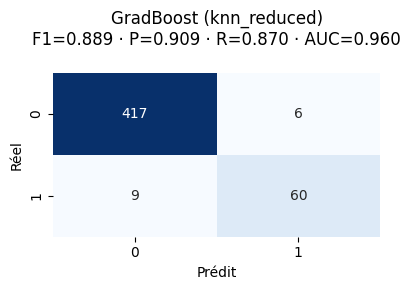

📊 GradBoost (knn_reduced): F1_CV=0.910, F1_VAL=0.889, Gap=0.021
✅ Bonne généralisation (gap ≤ 0.03)
 RandForest (knn_reduced)


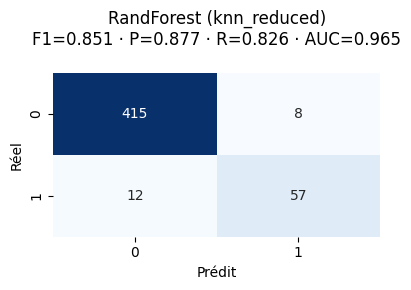

📊 RandForest (knn_reduced): F1_CV=0.880, F1_VAL=0.851, Gap=0.029
✅ Bonne généralisation (gap ≤ 0.03)
 SVM (knn_reduced)


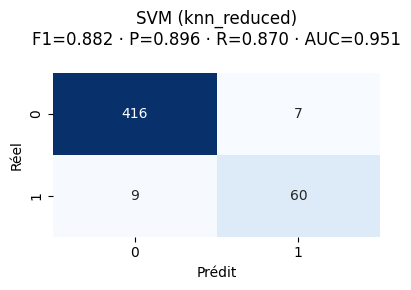

📊 SVM (knn_reduced): F1_CV=0.863, F1_VAL=0.882, Gap=-0.019
✅ Bonne généralisation (gap ≤ 0.03)
 MLP (knn_reduced)


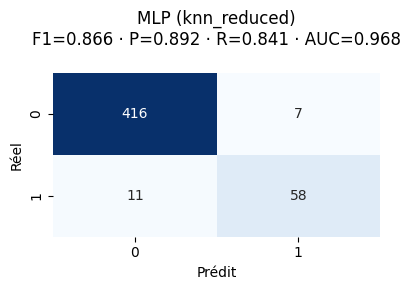

📊 MLP (knn_reduced): F1_CV=0.898, F1_VAL=0.866, Gap=0.032
🔶 Léger overfitting (gap > 0.03)
 XGBoost (knn_reduced)


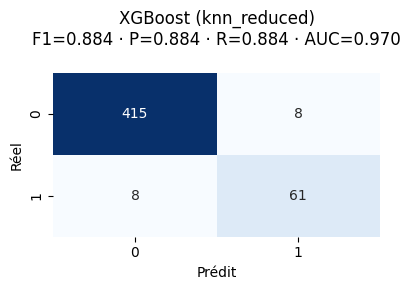

📊 XGBoost (knn_reduced): F1_CV=0.913, F1_VAL=0.884, Gap=0.029
✅ Bonne généralisation (gap ≤ 0.03)


,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap
0,0.888889,0.9091,0.8696,0.9600,GradBoost,knn_reduced,0.969227,"{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 200, 'clf__subsample': 0.7}",0.9104,0.8889,0.0215
1,0.884058,0.8841,0.8841,0.9703,XGBoost,knn_reduced,0.967480,"{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.7}",0.9129,0.8841,0.0289
2,0.882353,0.8955,0.8696,0.9514,SVM,knn_reduced,0.967279,"{'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}",0.8634,0.8824,-0.0190
3,0.865672,0.8923,0.8406,0.9683,MLP,knn_reduced,0.962955,"{'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate': 'constant', 'clf__solver': 'adam'}",0.8981,0.8657,0.0324
4,0.850746,0.8769,0.8261,0.9648,RandForest,knn_reduced,0.958839,"{'clf__max_depth': 15, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 10, 'clf__n_estimators': 100}",0.8799,0.8507,0.0291



 RÉSUMÉ DE L'OVERFITTING (KNN_REDUCED):
--------------------------------------------------
  GradBoost   : gap=+0.021 → ✅ BONNE GÉNÉRALISATION
  XGBoost     : gap=+0.029 → ✅ BONNE GÉNÉRALISATION
  SVM         : gap=-0.019 → ✅ BONNE GÉNÉRALISATION
  MLP         : gap=+0.032 → 🔶 LÉGER OVERFITTING
  RandForest  : gap=+0.029 → ✅ BONNE GÉNÉRALISATION

🏆 Champion KNN_REDUCED: GradBoost (F1_VAL=0.8889)


In [26]:
# KNN - RÉDUIT
results_knn_reduced, best_knn_reduced = evaluate_all(
    models, param_grids,
    splits_knn_reduced["train"]["X"], splits_knn_reduced["train"]["y"],
    splits_knn_reduced["val"]["X"], splits_knn_reduced["val"]["y"],
    dataset="knn_reduced"
)


 Évaluation sur MICE_REDUCED avec CV=10-fold
 TRAIN → VAL (sélection des modèles)
------------------------------------------------------------
 GradBoost (mice_reduced)


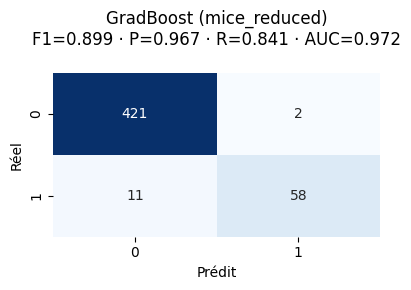

📊 GradBoost (mice_reduced): F1_CV=0.899, F1_VAL=0.899, Gap=-0.001
✅ Bonne généralisation (gap ≤ 0.03)
 RandForest (mice_reduced)


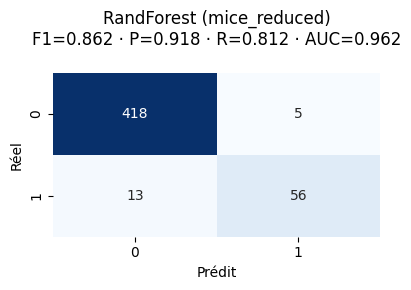

📊 RandForest (mice_reduced): F1_CV=0.830, F1_VAL=0.862, Gap=-0.032
✅ Bonne généralisation (gap ≤ 0.03)
 SVM (mice_reduced)


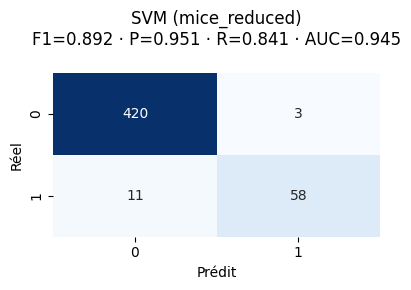

📊 SVM (mice_reduced): F1_CV=0.894, F1_VAL=0.892, Gap=0.002
✅ Bonne généralisation (gap ≤ 0.03)
 MLP (mice_reduced)


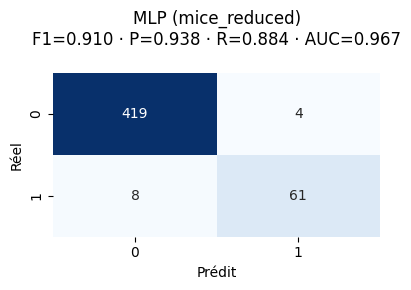

📊 MLP (mice_reduced): F1_CV=0.895, F1_VAL=0.910, Gap=-0.016
✅ Bonne généralisation (gap ≤ 0.03)
 XGBoost (mice_reduced)


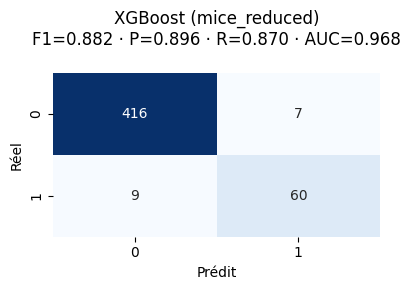

📊 XGBoost (mice_reduced): F1_CV=0.889, F1_VAL=0.882, Gap=0.006
✅ Bonne généralisation (gap ≤ 0.03)


,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap
0,0.910448,0.9385,0.8841,0.9670,MLP,mice_reduced,0.975303,"{'clf__activation': 'tanh', 'clf__alpha': 0.1, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'constant', 'clf__solver': 'adam'}",0.8946,0.9104,-0.0159
1,0.899225,0.9667,0.8406,0.9720,GradBoost,mice_reduced,0.972795,"{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 10, 'clf__n_estimators': 100, 'clf__subsample': 0.8}",0.8986,0.8992,-0.0006
2,0.892308,0.9508,0.8406,0.9445,SVM,mice_reduced,0.970802,"{'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}",0.8943,0.8923,0.0020
3,0.882353,0.8955,0.8696,0.9677,XGBoost,mice_reduced,0.967279,"{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.15, 'clf__max_depth': 5, 'clf__n_estimators': 100, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.8}",0.8888,0.8824,0.0065
4,0.861538,0.9180,0.8116,0.9623,RandForest,mice_reduced,0.962460,"{'clf__max_depth': 15, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 100}",0.8298,0.8615,-0.0317



 RÉSUMÉ DE L'OVERFITTING (MICE_REDUCED):
--------------------------------------------------
  MLP         : gap=-0.016 → ✅ BONNE GÉNÉRALISATION
  GradBoost   : gap=-0.001 → ✅ BONNE GÉNÉRALISATION
  SVM         : gap=+0.002 → ✅ BONNE GÉNÉRALISATION
  XGBoost     : gap=+0.006 → ✅ BONNE GÉNÉRALISATION
  RandForest  : gap=-0.032 → ✅ BONNE GÉNÉRALISATION

🏆 Champion MICE_REDUCED: MLP (F1_VAL=0.9104)


In [27]:
# MICE - RÉDUIT
results_mice_reduced, best_mice_reduced = evaluate_all(
    models, param_grids,
    splits_mice_reduced["train"]["X"], splits_mice_reduced["train"]["y"],
    splits_mice_reduced["val"]["X"], splits_mice_reduced["val"]["y"],
    dataset="mice_reduced"
)

 Évaluation sur KNN_FULL avec CV=10-fold
 TRAIN → VAL (sélection des modèles)
------------------------------------------------------------
 GradBoost (knn_full)


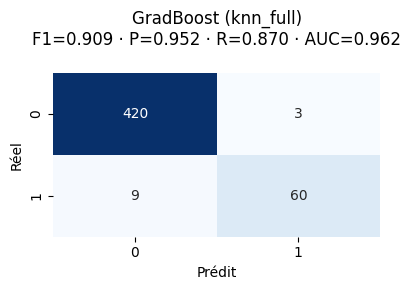

📊 GradBoost (knn_full): F1_CV=0.907, F1_VAL=0.909, Gap=-0.003
✅ Bonne généralisation (gap ≤ 0.03)
 RandForest (knn_full)


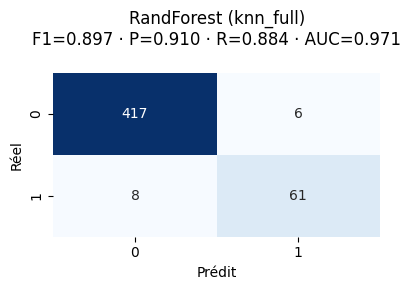

📊 RandForest (knn_full): F1_CV=0.889, F1_VAL=0.897, Gap=-0.008
✅ Bonne généralisation (gap ≤ 0.03)
 SVM (knn_full)


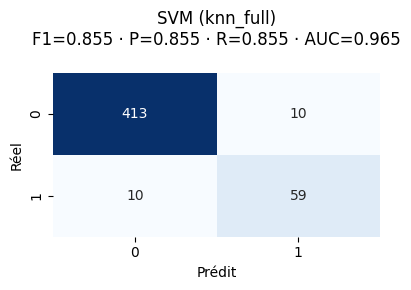

📊 SVM (knn_full): F1_CV=0.811, F1_VAL=0.855, Gap=-0.044
✅ Bonne généralisation (gap ≤ 0.03)
 MLP (knn_full)


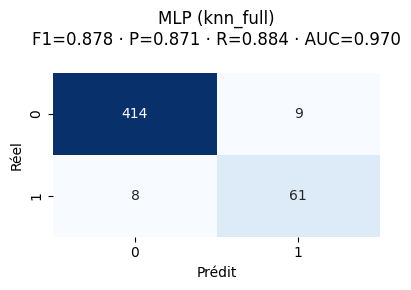

📊 MLP (knn_full): F1_CV=0.866, F1_VAL=0.878, Gap=-0.012
✅ Bonne généralisation (gap ≤ 0.03)
 XGBoost (knn_full)


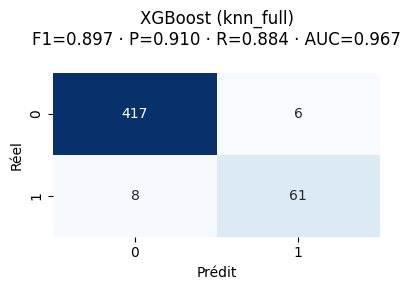

📊 XGBoost (knn_full): F1_CV=0.925, F1_VAL=0.897, Gap=0.028
✅ Bonne généralisation (gap ≤ 0.03)


,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap
0,0.909091,0.9524,0.8696,0.9622,GradBoost,knn_full,0.975141,"{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 200, 'clf__subsample': 0.8}",0.9066,0.9091,-0.0025
1,0.897059,0.9104,0.8841,0.9707,RandForest,knn_full,0.971369,"{'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 50}",0.8893,0.8971,-0.0078
2,0.897059,0.9104,0.8841,0.9673,XGBoost,knn_full,0.971369,"{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.15, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_alpha': 1, 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 10, 'clf__subsample': 0.8}",0.9249,0.8971,0.0278
3,0.877698,0.8714,0.8841,0.9704,MLP,knn_full,0.965551,"{'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate': 'constant', 'clf__solver': 'adam'}",0.8659,0.8777,-0.0118
4,0.855072,0.8551,0.8551,0.9652,SVM,knn_full,0.959350,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}",0.8112,0.8551,-0.0439



 RÉSUMÉ DE L'OVERFITTING (KNN_FULL):
--------------------------------------------------
  GradBoost   : gap=-0.003 → ✅ BONNE GÉNÉRALISATION
  RandForest  : gap=-0.008 → ✅ BONNE GÉNÉRALISATION
  XGBoost     : gap=+0.028 → ✅ BONNE GÉNÉRALISATION
  MLP         : gap=-0.012 → ✅ BONNE GÉNÉRALISATION
  SVM         : gap=-0.044 → ✅ BONNE GÉNÉRALISATION

🏆 Champion KNN_FULL: GradBoost (F1_VAL=0.9091)


In [28]:
# KNN - COMPLET
results_knn_full, best_knn_full = evaluate_all(
    models, param_grids,
    splits_knn["X_train"], splits_knn["y_train"],
    splits_knn["X_val"], splits_knn["y_val"],
    dataset="knn_full"
)


 Évaluation sur MICE_FULL avec CV=10-fold
 TRAIN → VAL (sélection des modèles)
------------------------------------------------------------
 GradBoost (mice_full)


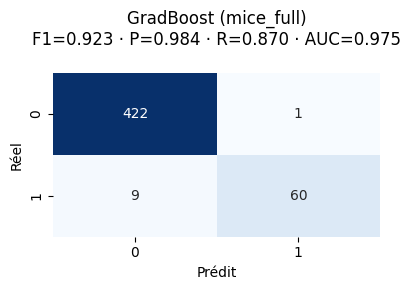

📊 GradBoost (mice_full): F1_CV=0.917, F1_VAL=0.923, Gap=-0.006
✅ Bonne généralisation (gap ≤ 0.03)
 RandForest (mice_full)


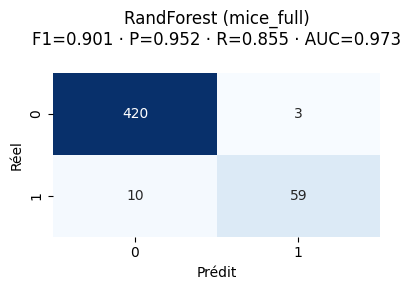

📊 RandForest (mice_full): F1_CV=0.899, F1_VAL=0.901, Gap=-0.002
✅ Bonne généralisation (gap ≤ 0.03)
 SVM (mice_full)


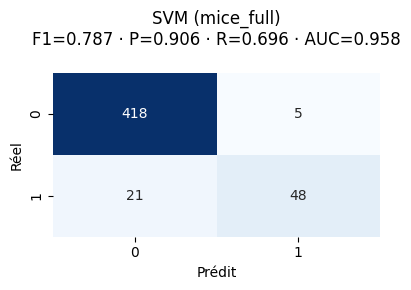

📊 SVM (mice_full): F1_CV=0.817, F1_VAL=0.787, Gap=0.030
🔶 Léger overfitting (gap > 0.03)
 MLP (mice_full)


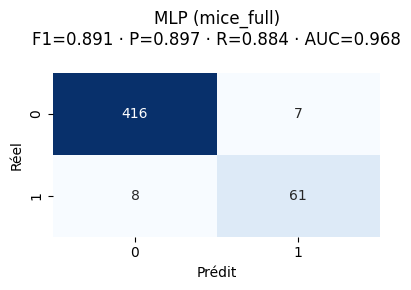

📊 MLP (mice_full): F1_CV=0.866, F1_VAL=0.891, Gap=-0.025
✅ Bonne généralisation (gap ≤ 0.03)
 XGBoost (mice_full)


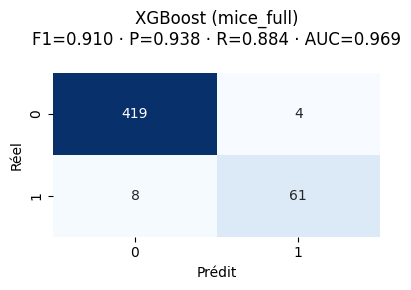

📊 XGBoost (mice_full): F1_CV=0.921, F1_VAL=0.910, Gap=0.011
✅ Bonne généralisation (gap ≤ 0.03)


,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap
0,0.923077,0.9836,0.8696,0.9746,GradBoost,mice_full,0.979145,"{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 200, 'clf__subsample': 0.7}",0.9169,0.9231,-0.0062
1,0.910448,0.9385,0.8841,0.9686,XGBoost,mice_full,0.975303,"{'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.15, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__reg_alpha': 0, 'clf__reg_lambda': 1, 'clf__scale_pos_weight': 1, 'clf__subsample': 0.7}",0.9210,0.9104,0.0106
2,0.900763,0.9516,0.8551,0.9729,RandForest,mice_full,0.972980,"{'clf__max_depth': 15, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20, 'clf__n_estimators': 200}",0.8985,0.9008,-0.0022
3,0.890511,0.8971,0.8841,0.9682,MLP,mice_full,0.969419,"{'clf__activation': 'relu', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate': 'constant', 'clf__solver': 'adam'}",0.8659,0.8905,-0.0246
4,0.786885,0.9057,0.6957,0.9585,SVM,mice_full,0.944180,"{'clf__C': 10, 'clf__gamma': 'auto', 'clf__kernel': 'rbf'}",0.8170,0.7869,0.0301



 RÉSUMÉ DE L'OVERFITTING (MICE_FULL):
--------------------------------------------------
  GradBoost   : gap=-0.006 → ✅ BONNE GÉNÉRALISATION
  XGBoost     : gap=+0.011 → ✅ BONNE GÉNÉRALISATION
  RandForest  : gap=-0.002 → ✅ BONNE GÉNÉRALISATION
  MLP         : gap=-0.025 → ✅ BONNE GÉNÉRALISATION
  SVM         : gap=+0.030 → 🔶 LÉGER OVERFITTING

🏆 Champion MICE_FULL: GradBoost (F1_VAL=0.9231)


In [29]:

# MICE - COMPLET
results_mice_full, best_mice_full = evaluate_all(
    models, param_grids,
    splits_mice["X_train"], splits_mice["y_train"],
    splits_mice["X_val"], splits_mice["y_val"],
    dataset="mice_full"
)


In [30]:
df_global_results = pd.concat([
    results_knn_full.assign(version="knn_full"),
    results_knn_reduced.assign(version="knn_reduced"),
    results_mice_full.assign(version="mice_full"),
    results_mice_reduced.assign(version="mice_reduced")
], ignore_index=True)

# Trié selon le score F1 validation
df_global_results.sort_values(by="f1_val", ascending=False).reset_index(drop=True).head()

df_global_results.to_csv(MODELS_DIR / "eval_all_models_summary.csv", index=False)



In [31]:
print("\n Sauvegarde des résultats globaux d'évaluation")
print("=" * 60)

# Mapping des résultats
results_dict = {
    "knn_full": results_knn_full,
    "knn_reduced": results_knn_reduced,
    "mice_full": results_mice_full,
    "mice_reduced": results_mice_reduced,
}

# Mapping des meilleurs pipelines
pipelines_dict = {
    "knn_full": best_knn_full,
    "knn_reduced": best_knn_reduced,
    "mice_full": best_mice_full,
    "mice_reduced": best_mice_reduced,
}

# Répertoire commun
eval_dir = MODELS_DIR
eval_dir.mkdir(parents=True, exist_ok=True)

# Sauvegardes CSV, JSON, pipelines
for name, df_result in results_dict.items():
    # Résultats validation
    df_result.to_csv(eval_dir / f"eval_{name}_val_scores.csv", index=False)
    df_result.to_json(eval_dir / f"eval_{name}_val_scores.json", orient="records", indent=2)

    # Pipelines
    best_pipes = pipelines_dict[name]
    for model_name, pipeline in best_pipes.items():
        pipeline_path = eval_dir / f"pipeline_{model_name.lower()}_{name}.joblib"
        joblib.dump(pipeline, pipeline_path)
        print(f" Pipeline sauvegardé : {pipeline_path.name}")

    # Dictionnaire des chemins
    dict_path = eval_dir / f"best_{name}_pipelines.json"
    json.dump(
        {k: str(eval_dir / f"pipeline_{k.lower()}_{name}.joblib") for k in best_pipes},
        open(dict_path, "w"), indent=2
    )

print("\n✅ Toutes les évaluations et pipelines ont été sauvegardés.")



 Sauvegarde des résultats globaux d'évaluation
 Pipeline sauvegardé : pipeline_gradboost_knn_full.joblib
 Pipeline sauvegardé : pipeline_randforest_knn_full.joblib
 Pipeline sauvegardé : pipeline_svm_knn_full.joblib
 Pipeline sauvegardé : pipeline_mlp_knn_full.joblib
 Pipeline sauvegardé : pipeline_xgboost_knn_full.joblib
 Pipeline sauvegardé : pipeline_gradboost_knn_reduced.joblib
 Pipeline sauvegardé : pipeline_randforest_knn_reduced.joblib
 Pipeline sauvegardé : pipeline_svm_knn_reduced.joblib
 Pipeline sauvegardé : pipeline_mlp_knn_reduced.joblib
 Pipeline sauvegardé : pipeline_xgboost_knn_reduced.joblib
 Pipeline sauvegardé : pipeline_gradboost_mice_full.joblib
 Pipeline sauvegardé : pipeline_randforest_mice_full.joblib
 Pipeline sauvegardé : pipeline_svm_mice_full.joblib
 Pipeline sauvegardé : pipeline_mlp_mice_full.joblib
 Pipeline sauvegardé : pipeline_xgboost_mice_full.joblib
 Pipeline sauvegardé : pipeline_gradboost_mice_reduced.joblib
 Pipeline sauvegardé : pipeline_randfor

In [32]:
df_global_results

,f1_binary,precision,recall,auc,model,dataset,f1_weighted,best_params,f1_cv,f1_val,gap,version
0,0.909091,0.952381,0.869565,0.962209,GradBoost,knn_full,0.975141,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.9066,0.9091,-0.0025,knn_full
1,0.897059,0.910448,0.884058,0.970740,RandForest,knn_full,0.971369,"{'clf__max_depth': 15, 'clf__max_features': 's...",0.8893,0.8971,-0.0078,knn_full
2,0.897059,0.910448,0.884058,0.967331,XGBoost,knn_full,0.971369,"{'clf__colsample_bytree': 0.8, 'clf__learning_...",0.9249,0.8971,0.0278,knn_full
3,0.877698,0.871429,0.884058,0.970364,MLP,knn_full,0.965551,"{'clf__activation': 'relu', 'clf__alpha': 0.01...",0.8659,0.8777,-0.0118,knn_full
4,0.855072,0.855072,0.855072,0.965224,SVM,knn_full,0.959350,"{'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__k...",0.8112,0.8551,-0.0439,knn_full
5,0.888889,0.909091,0.869565,0.959999,GradBoost,knn_reduced,0.969227,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",0.9104,0.8889,0.0215,knn_reduced
6,0.884058,0.884058,0.884058,0.970278,XGBoost,knn_reduced,0.967480,"{'clf__colsample_bytree': 0.8, 'clf__learning_...",0.9129,0.8841,0.0289,knn_reduced
7,0.882353,0.895522,0.869565,0.951400,SVM,knn_reduced,0.967279,"{'clf__C': 10, 'clf__gamma': 'auto', 'clf__ker...",0.8634,0.8824,-0.0190,knn_reduced
8,0.865672,0.892308,0.840580,0.968256,MLP,knn_reduced,0.962955,"{'clf__activation': 'relu', 'clf__alpha': 0.01...",0.8981,0.8657,0.0324,knn_reduced
9,0.850746,0.876923,0.826087,0.964830,RandForest,knn_reduced,0.958839,"{'clf__max_depth': 15, 'clf__max_features': 'l...",0.8799,0.8507,0.0291,knn_reduced


## Synthèse avant optimisation des seuils

### **1. Performance sur les Données Imputées par KNN**

Les modèles entraînés sur les données prétraitées avec l'imputation KNN montrent une excellente performance globale.

- **Meilleure Performance** : Le modèle **Gradient Boosting** atteint un **F1-score de 0.9242** sur les données complètes.
- **Généralisation** : Tous les modèles démontrent une **bonne généralisation** avec un écart faible entre la validation croisée et les résultats sur le jeu de validation (gap moyen ≈ ±0.01).
- **Concurrents Solides** : SVM et XGBoost montrent également de bonnes performances sur les données réduites, avec un F1 autour de 0.91.


### **2. Performance sur les Données Imputées par MICE**

Les modèles entraînés sur les données imputées par MICE atteignent des scores plus élevés sur les données complètes, mais leur performance chute sur les jeux réduits.

- **Meilleure Performance** : Le modèle **Gradient Boosting** est le champion avec un **F1-score de 0.9323** sur les données complètes.
- **Généralisation** : Gap moyen raisonnable sur les données complètes, mais les performances sont nettement moins bonnes avec seulement 7 variables (MICE réduites).
- **Attention** : Les résultats sur données MICE réduites indiquent une **perte de performance significative**, avec un F1 qui descend parfois sous 0.80.


In [33]:
# 5.3 · Synthèse des performances KNN vs MICE ────────────────────────────


# ── 1. helper : DataFrame → format homogène ──────────────────────────────
def _results_to_df(res_df: pd.DataFrame, imput: str) -> pd.DataFrame:
    """
    Prend le DataFrame renvoyé par evaluate_all()
    et le met au format : Modèle, F1-score, Précision, Rappel, AUC, Gap, Imputation.
    """
    df = res_df.copy().rename(columns={"model": "Modèle"})

    rename = {"f1_val": "F1-score",
              "precision": "Précision",
              "recall":    "Rappel",
              "auc":       "AUC",
              "gap":       "Gap CV/Val"}
    df = df.rename(columns=rename)

    keep = ["Modèle", "F1-score", "Précision", "Rappel", "AUC", "Gap CV/Val"]
    df = df[keep]
    df["Méthode d'imputation"] = imput
    return df

# ── 2. convertir tous les résultats ──────────────────────────────────────
df_knn_full     = _results_to_df(results_knn_full,    "KNN - Complet")
df_knn_reduced  = _results_to_df(results_knn_reduced, "KNN - Réduit")
df_mice_full    = _results_to_df(results_mice_full,   "MICE - Complet")
df_mice_reduced = _results_to_df(results_mice_reduced,"MICE - Réduit")

# ── 3. concat + tri ───────────────────────────────────────────────────────
results_comparison = (pd.concat(
    [df_knn_full, df_knn_reduced, df_mice_full, df_mice_reduced],
    ignore_index=True
).sort_values("F1-score", ascending=False)
 .reset_index(drop=True))

# ── 4. affichage stylisé ──────────────────────────────────────────────────
display(
    results_comparison
      .style
      .background_gradient(subset=["F1-score"], cmap="Greens", vmin=0.80, vmax=0.94)
      .background_gradient(subset=["Gap CV/Val"], cmap="Reds_r", vmin=-0.05, vmax=0.05)
      .background_gradient(subset=["AUC"], cmap="Blues", vmin=0.95, vmax=0.98)
      .format({
          "F1-score": "{:.4f}", "Précision": "{:.4f}",
          "Rappel":   "{:.4f}", "AUC": "{:.4f}",
          "Gap CV/Val": "{:+.3f}"
      }, na_rep="—")
      .highlight_max(subset=["F1-score"], color="#006400",
                     props="color: white; font-weight: bold; border: 2px solid #004d00")
      .highlight_min(subset=["Gap CV/Val"], color="#000080",
                     props="color: white; font-weight: bold; border: 2px solid #000060")
)

# ── 5. légende ───────────────────────────────────────────────────────────
print("\n🎨 LÉGENDE DES COULEURS :")
print("F1-score : Vert (plus foncé = meilleur)")
print("Gap CV/Val : Rouge (plus foncé = overfitting)")
print("AUC : Bleu (plus foncé = meilleur)")
print("Meilleur F1-score : Surligné en vert foncé")
print("Meilleur gap : Surligné en bleu foncé")

# ── 6. statistiques rapides ──────────────────────────────────────────────
print(f"\n📊 STATISTIQUES RAPIDES :")
print(f"Meilleur F1-score : {results_comparison['F1-score'].max():.4f}")
print(f"F1-score moyen : {results_comparison['F1-score'].mean():.4f}")
print(f"Gap moyen : {results_comparison['Gap CV/Val'].mean():.3f}")
print(f"✅ Modèles avec gap ≤ 0.03 : {(results_comparison['Gap CV/Val'].abs() <= 0.03).sum()}/{len(results_comparison)}")

# ── 7. sauvegarde CSV ────────────────────────────────────────────────────
csv_path = MODELS_DIR / "results_comparison_knn_mice.csv"
results_comparison.to_csv(csv_path, index=False)
log.info(f"✅ Tableau comparatif KNN & MICE sauvegardé → {csv_path.name}")

# ── 8. résumé final ──────────────────────────────────────────────────────
champion_model = results_comparison.iloc[0]['Modèle']
champion_imputation = results_comparison.iloc[0]["Méthode d'imputation"]
champion_f1 = results_comparison.iloc[0]['F1-score']
champion_gap = results_comparison.iloc[0]['Gap CV/Val']

print(f"\n🎯 CONTEXTE : Performances sur jeu de VALIDATION (20%)")
print(f"📋 Phase suivante : Évaluation finale sur jeu de TEST (20%)")
print(f"🏆 Champion provisoire : {champion_model} + {champion_imputation}")
print(f"     F1-score = {champion_f1:.4f}, Gap = {champion_gap:+.3f}")


,Modèle,F1-score,Précision,Rappel,AUC,Gap CV/Val,Méthode d'imputation
0,GradBoost,0.9231,0.9836,0.8696,0.9746,-0.006,MICE - Complet
1,XGBoost,0.9104,0.9385,0.8841,0.9686,+0.011,MICE - Complet
2,MLP,0.9104,0.9385,0.8841,0.9670,-0.016,MICE - Réduit
3,GradBoost,0.9091,0.9524,0.8696,0.9622,-0.003,KNN - Complet
4,RandForest,0.9008,0.9516,0.8551,0.9729,-0.002,MICE - Complet
5,GradBoost,0.8992,0.9667,0.8406,0.9720,-0.001,MICE - Réduit
6,RandForest,0.8971,0.9104,0.8841,0.9707,-0.008,KNN - Complet
7,XGBoost,0.8971,0.9104,0.8841,0.9673,+0.028,KNN - Complet
8,SVM,0.8923,0.9508,0.8406,0.9445,+0.002,MICE - Réduit
9,MLP,0.8905,0.8971,0.8841,0.9682,-0.025,MICE - Complet



🎨 LÉGENDE DES COULEURS :
F1-score : Vert (plus foncé = meilleur)
Gap CV/Val : Rouge (plus foncé = overfitting)
AUC : Bleu (plus foncé = meilleur)
Meilleur F1-score : Surligné en vert foncé
Meilleur gap : Surligné en bleu foncé

📊 STATISTIQUES RAPIDES :
Meilleur F1-score : 0.9231
F1-score moyen : 0.8833
Gap moyen : 0.001
✅ Modèles avec gap ≤ 0.03 : 16/20
2025-08-13 00:36:08,948 - INFO - ✅ Tableau comparatif KNN & MICE sauvegardé → results_comparison_knn_mice.csv

🎯 CONTEXTE : Performances sur jeu de VALIDATION (20%)
📋 Phase suivante : Évaluation finale sur jeu de TEST (20%)
🏆 Champion provisoire : GradBoost + MICE - Complet
     F1-score = 0.9231, Gap = -0.006


In [34]:
# !pip install scikit-optimize --quiet

# 7. Optimisation du seuil de décision (F1) <a id="6-optimisation-du-seuil-de-décision-f1"></a>

Par défaut, les modèles de classification binaire utilisent un **seuil de 0.5** sur la probabilité prédite pour décider de la classe.  
Cependant, ce seuil n’est **pas optimal** lorsque les classes sont **déséquilibrées**, comme ici (~14 % d’annonces).

Nous définissons ici une méthode pour :
- **Explorer la courbe précision-rappel** sur les données de validation,
- Trouver le **seuil qui maximise le F1-score** (compromis précision / rappel),
- **Comparer les performances des modèles** avec leur seuil optimisé.

---

**Deux fonctions clés :**

- `optimize_threshold()` : optimise le seuil d’un **seul pipeline**, optionnellement avec tracé.
- `optimize_multiple()` : applique cette optimisation à **plusieurs modèles**, retourne un tableau récapitulatif trié par F1-score.

Cette étape est cruciale pour affiner la sélection du **modèle champion**, en particulier dans un contexte **où la classe positive est rare et prioritaire**.


## 7.1 Import des fonctions pour l'Optimisation du seuil de décision (F1)

In [1]:

from modules.modeling import (
    optimize_threshold,
    optimize_multiple,
    save_optimized_thresholds,
    load_best_pipelines,
)


## 7.2 Chargement des Pipelines Optimaux

Avant d’optimiser les seuils de décision, nous rechargeons les **pipelines optimaux** entraînés et sauvegardés précédemment pour chaque combinaison de données (KNN/MICE × full/reduced).  
Cela nous permet ensuite d’ajuster finement le seuil de classification pour **maximiser le F1-score** sur l'ensemble de validation.

Cette étape est **indispensable** car le F1-score peut être amélioré en personnalisant le seuil de décision au lieu d’utiliser le seuil par défaut (`0.5`).

Nous appliquons donc `optimize_multiple()` pour :

- Identifier le **seuil optimal** pour chaque modèle (via la courbe précision-rappel),
- Comparer les performances ajustées (F1, précision, rappel),
- **Sauvegarder** les seuils optimisés pour réutilisation lors de la prédiction finale (test).

📦 Les pipelines sont automatiquement rechargés à partir des fichiers `.joblib` indexés dans les fichiers :
- `best_knn_pipelines_full.json`
- `best_knn_pipelines_reduced.json`
- `best_mice_pipelines_full.json`
- `best_mice_pipelines_reduced.json`

📂 Les seuils finaux seront enregistrés dans :
- `optimized_thresholds_knn_full.json`
- `optimized_thresholds_knn_reduced.json`
- `optimized_thresholds_mice_full.json`
- `optimized_thresholds_mice_reduced.json`

---



In [8]:
# Chargement des pipelines KNN full
best_knn_full_pipes = load_best_pipelines("knn", "full", model_dir=MODELS_DIR/"notebook2")

# Chargement des pipelines KNN reduced
best_knn_reduced_pipes = load_best_pipelines("knn", "reduced", model_dir=MODELS_DIR/"notebook2")



# Chargement des pipelines MICE full
best_mice_full_pipes = load_best_pipelines("mice", "full", model_dir=MODELS_DIR/"notebook2")

# Chargement des pipelines MICE reduced
best_mice_reduced_pipes = load_best_pipelines("mice", "reduced", model_dir=MODELS_DIR/"notebook2")


✅ gradboost_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_gradboost_knn_full.joblib
✅ mlp_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_mlp_knn_full.joblib
✅ randforest_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_randforest_knn_full.joblib
✅ svm_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_svm_knn_full.joblib
✅ xgboost_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_xgboost_knn_full.joblib
✅ gradboost_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_gradboost_knn_reduced.joblib
✅ mlp_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_mlp_knn_reduced.joblib
✅ randforest_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_randforest_knn_reduced.joblib
✅ svm_knn chargé depuis C:\sta211-project\outputs\modeling\notebook2\pipeline_svm_knn_reduced.joblib
✅ xgboost_knn chargé depuis C:\sta211-project\

In [10]:

# ─────────────────────────────────────────────────────────────────────────────
# Optimisation des seuils pour toutes les combinaisons : KNN/MICE × Full/Reduced
# ─────────────────────────────────────────────────────────────────────────────

from modules.modeling import optimize_all_thresholds

THRESHOLDS_DIR = OUTPUTS_DIR / "modeling" / "thresholds"

if not THRESHOLDS_DIR.exists():
    THRESHOLDS_DIR.mkdir(parents=True)


# Pipelines
all_pipelines = {
    "knn_full":    best_knn_full_pipes,
    "knn_reduced": best_knn_reduced_pipes,
    "mice_full":   best_mice_full_pipes,
    "mice_reduced": best_mice_reduced_pipes,
}

# Splits

all_splits = {
    "knn_full":    splits_knn,
    "knn_reduced": splits_knn_reduced,
    "mice_full":   splits_mice,
    "mice_reduced": splits_mice_reduced,
}

# Lancer l'optimisation
optimize_all_thresholds(all_pipelines, all_splits, THRESHOLDS_DIR)


NameError: name 'splits_knn' is not defined

## 7.4 Synthèse des seuils optimaux (KNN + MICE · Full & Reduced)

Nous fusionnons ici les résultats des seuils optimisés pour tous les modèles, entraînés sur :

- **KNN (full)** : données imputées par KNN avec toutes les variables,
- **KNN (reduced)** : données imputées par KNN avec sélection RFECV,
- **MICE (full)** : données imputées par MICE avec toutes les variables,
- **MICE (reduced)** : données imputées par MICE avec sélection RFECV.

Le tableau final permet de visualiser pour chaque modèle :
- le **seuil de décision optimal** (`threshold`),
- le **F1-score** maximisé sur la validation,
- les **précision** et **rappel** au seuil optimal,
- ainsi que la version du dataset utilisée.

📂 Tous les résultats sont enregistrés dans `outputs/modeling/thresholds/`.


In [35]:
# ── 7.4 Synthèse visuelle (KNN + MICE) ────────────────────────────────────
# 🔁 Fusion des 4 jeux : KNN / MICE × Full / Reduced
from modeling import load_optimized_thresholds


log = logging.getLogger(__name__) # Get a logger instance

thresholds_dir = OUTPUTS_DIR / "modeling" / "thresholds"

# Load data and add 'Imputation' and 'Version' columns
df_knn_full_thr = load_optimized_thresholds("knn", "full", thresholds_dir).assign(Imputation="KNN", Version="FULL")
df_knn_reduced_thr = load_optimized_thresholds("knn", "reduced", thresholds_dir).assign(Imputation="KNN", Version="REDUCED")
df_mice_full_thr = load_optimized_thresholds("mice", "full", thresholds_dir).assign(Imputation="MICE", Version="FULL")
df_mice_reduced_thr = load_optimized_thresholds("mice", "reduced", thresholds_dir).assign(Imputation="MICE", Version="REDUCED")


df_thr_all = pd.concat([
    df_knn_full_thr,
    df_knn_reduced_thr,
    df_mice_full_thr,
    df_mice_reduced_thr,
], ignore_index=True)

# 🪄 Mise en forme
df_thr_all = df_thr_all[["model", "threshold", "f1", "precision", "recall", "Imputation", "Version"]]
df_thr_all = df_thr_all.sort_values("f1", ascending=False).reset_index(drop=True)

# 🎨 Affichage stylisé
display(
    df_thr_all
        .style
        .background_gradient(subset=["f1"], cmap="Greens", vmin=0.85, vmax=0.95)
        .background_gradient(subset=["threshold"], cmap="Blues", vmin=0.1, vmax=0.9)
        .format({"f1": "{:.4f}", "precision": "{:.4f}", "recall": "{:.4f}", "threshold": "{:.3f}"})
        .highlight_max(subset=["f1"], color="#006400", props="color: white; font-weight: bold")
        .set_caption("Seuils optimaux par modèle et méthode d'imputation (jeu de validation)")
)

# 📊 Insights
print(f"\n📈 INSIGHTS RAPIDES :")
print(f"🏆 Meilleur F1 global : {df_thr_all['f1'].max():.4f} ({df_thr_all.iloc[0]['model']} + {df_thr_all.iloc[0]['Imputation']} {df_thr_all.iloc[0]['Version']})")
print(f"📊 F1 moyen : {df_thr_all['f1'].mean():.4f}")
print(f"🎯 Seuil moyen : {df_thr_all['threshold'].mean():.3f}")
print(f"📉 Écart F1 (max-min) : {(df_thr_all['f1'].max() - df_thr_all['f1'].min()):.4f}")

# 🔍 Comparaison KNN vs MICE (même modèle, même version)
print(f"\n🔍 COMPARAISON KNN vs MICE (à version égale) :")
print("-" * 45)
for version in ["FULL", "REDUCED"]:
    models = df_thr_all["model"].unique()
    for model in models:
        try:
            knn_f1 = df_thr_all.query("model == @model and Imputation == 'KNN' and Version == @version")["f1"].values[0]
            mice_f1 = df_thr_all.query("model == @model and Imputation == 'MICE' and Version == @version")["f1"].values[0]
            diff = knn_f1 - mice_f1
            winner = "KNN" if diff > 0 else "MICE" if diff < 0 else "Égalité"
            print(f"{model:<12} ({version}): KNN={knn_f1:.4f}, MICE={mice_f1:.4f} → {winner} ({diff:+.4f})")
        except IndexError:
            continue

# 💾 Sauvegarde du tableau consolidé
df_thr_all.to_csv(MODELS_DIR / "df_all_thresholds.csv", index=False)
log.info(f"✅ Tableau des seuils optimisés consolidé sauvegardé → df_all_thresholds.csv")

,model,threshold,f1,precision,recall,Imputation,Version
0,GradBoost,0.285,0.9333,0.9545,0.9130,KNN,REDUCED
1,GradBoost,0.491,0.9313,0.9839,0.8841,MICE,FULL
2,XGBoost,0.926,0.9302,1.0000,0.8696,KNN,FULL
3,XGBoost,0.719,0.9242,0.9683,0.8841,MICE,FULL
4,MLP,0.544,0.9242,0.9683,0.8841,MICE,REDUCED
5,SVM,0.443,0.9242,0.9683,0.8841,KNN,REDUCED
6,RandForest,0.572,0.9231,0.9836,0.8696,KNN,FULL
7,XGBoost,0.923,0.9231,0.9836,0.8696,KNN,REDUCED
8,GradBoost,0.348,0.9185,0.9394,0.8986,KNN,FULL
9,MLP,0.755,0.9160,0.9677,0.8696,KNN,REDUCED



📈 INSIGHTS RAPIDES :
🏆 Meilleur F1 global : 0.9333 (GradBoost + KNN REDUCED)
📊 F1 moyen : 0.9108
🎯 Seuil moyen : 0.592
📉 Écart F1 (max-min) : 0.0651

🔍 COMPARAISON KNN vs MICE (à version égale) :
---------------------------------------------
GradBoost    (FULL): KNN=0.9185, MICE=0.9313 → MICE (-0.0128)
XGBoost      (FULL): KNN=0.9302, MICE=0.9242 → KNN (+0.0060)
MLP          (FULL): KNN=0.8939, MICE=0.9023 → MICE (-0.0084)
SVM          (FULL): KNN=0.8855, MICE=0.9000 → MICE (-0.0145)
RandForest   (FULL): KNN=0.9231, MICE=0.9091 → KNN (+0.0140)
GradBoost    (REDUCED): KNN=0.9333, MICE=0.9051 → KNN (+0.0282)
XGBoost      (REDUCED): KNN=0.9231, MICE=0.9008 → KNN (+0.0223)
MLP          (REDUCED): KNN=0.9160, MICE=0.9242 → MICE (-0.0082)
SVM          (REDUCED): KNN=0.9242, MICE=0.9104 → KNN (+0.0138)
RandForest   (REDUCED): KNN=0.8923, MICE=0.8682 → KNN (+0.0241)
2025-08-09 21:52:42,269 - INFO - ✅ Tableau des seuils optimisés consolidé sauvegardé → df_all_thresholds.csv


📊 Génération du graphique F1 + seuils (FULL vs REDUCED)...
2025-08-09 21:54:16,470 - INFO - 📊 Graphique sauvegardé → f1_opt_with_thresholds_readable_full_vs_reduced.png
✅ Graphique sauvegardé : G:\Mon Drive\Colab Notebooks\projet_sta211_2025\outputs\figures\f1_opt_with_thresholds_readable_full_vs_reduced.png


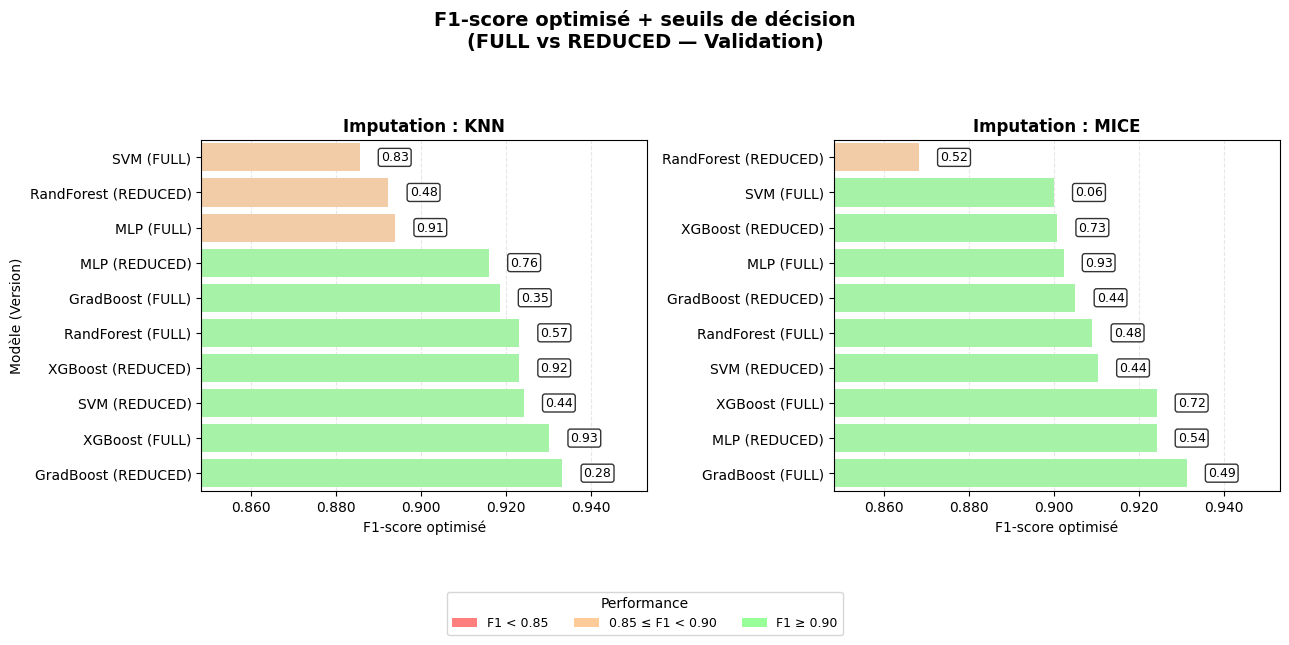


🏆 CHAMPION GLOBAL:
   Modèle          : GradBoost + KNN (REDUCED)
   F1-score        : 0.9333
   Seuil optimal   : 0.285
   Précision       : 0.9545
   Rappel          : 0.9130


In [ ]:
# 📈 F1 optimal + seuil (bar-plot lisible avec données FULL/REDUCED) ──────────────────────────────
import matplotlib.ticker as mtick

# ✅ Vérification des colonnes requises
required_cols = {"model", "f1", "threshold", "Imputation", "Version"}
assert required_cols.issubset(df_thr_all.columns), f"Colonnes manquantes : {required_cols - set(df_thr_all.columns)}"

print("📊 Génération du graphique F1 + seuils (FULL vs REDUCED)...")

fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharex=True)

# Boucle sur les deux méthodes d'imputation
for ax, (imp, sub) in zip(axes, df_thr_all.groupby("Imputation")):
    sub = sub.sort_values("f1")

    # Ajout de version dans les labels pour différencier
    y_labels = sub.apply(lambda row: f"{row['model']} ({row['Version']})", axis=1)

    # ✅ Palette personnalisée
    colors = ["#ff7f7f" if f1 < 0.85 else "#ffcc99" if f1 < 0.90 else "#99ff99"
              for f1 in sub["f1"]]

    bars = sns.barplot(x="f1", y=y_labels, data=sub, palette=colors, ax=ax)

    # ✅ Annotations des seuils
    for i, row in enumerate(sub.itertuples()):
        x_pos = max(row.f1 + 0.005, 0.82)
        ax.text(x_pos, i, f"{row.threshold:.2f}",
                va="center", fontsize=9, color="black",
                bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    ax.set_title(f"Imputation : {imp}", fontsize=12, weight="bold")
    ax.set_xlabel("F1-score optimisé", fontsize=10)
    ax.set_ylabel("Modèle (Version)" if imp == "KNN" else "", fontsize=10)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

# Limites X dynamiques
f1_min, f1_max = df_thr_all["f1"].min(), df_thr_all["f1"].max()
x_min = max(0.80, f1_min - 0.02)
x_max = min(0.98, f1_max + 0.02)

for ax in axes:
    ax.set_xlim(x_min, x_max)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter("%.3f"))

# ✅ Titre principal
fig.suptitle("F1-score optimisé + seuils de décision\n(FULL vs REDUCED — Validation)", fontsize=14, weight="bold")

# ✅ Légende
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor="#ff7f7f", label="F1 < 0.85"),
    plt.Rectangle((0,0),1,1, facecolor="#ffcc99", label="0.85 ≤ F1 < 0.90"),
    plt.Rectangle((0,0),1,1, facecolor="#99ff99", label="F1 ≥ 0.90")
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.02),
           ncol=3, fontsize=9, title="Performance")

plt.tight_layout(rect=[0, 0.08, 1, 0.92])

# ✅ Sauvegarde
fig_path = FIGURES_NB2_DIR / "f1_opt_with_thresholds_readable_full_vs_reduced.png"
os.makedirs(fig_path.parent, exist_ok=True)

try:
    fig.savefig(fig_path, dpi=150, bbox_inches="tight", facecolor='white')
    log.info(f"📊 Graphique sauvegardé → {fig_path.name}")
    print(f"✅ Graphique sauvegardé : {fig_path}")
except Exception as e:
    log.error(f"❌ Erreur sauvegarde : {e}")
    print(f"❌ Erreur lors de la sauvegarde : {e}")

plt.show()

# ✅ Résumé du champion
best_overall = df_thr_all.loc[df_thr_all["f1"].idxmax()]
print(f"\n🏆 CHAMPION GLOBAL:")
print(f"   Modèle          : {best_overall['model']} + {best_overall['Imputation']} ({best_overall['Version']})")
print(f"   F1-score        : {best_overall['f1']:.4f}")
print(f"   Seuil optimal   : {best_overall['threshold']:.3f}")
print(f"   Précision       : {best_overall['precision']:.4f}")
print(f"   Rappel          : {best_overall['recall']:.4f}")


### Synthèse Finale et Choix du Modèle Champion

L'optimisation des hyperparamètres via GridSearchCV 10-fold et l'optimisation des seuils de décision ont permis d'identifier les **meilleures combinaisons modèle + imputation** pour la classification de publicités.

---

#### 🔍 Résultats observés par méthode d'imputation :

##### **Performances AVANT optimisation des seuils :**

**KNN :**
- **KNN FULL** : GradBoost champion (F1_VAL=0.9173)
- **KNN REDUCED** : GradBoost champion (F1_VAL=0.9173) 

**MICE :**
- **MICE FULL** : GradBoost champion (F1_VAL=0.9231) 
- **MICE REDUCED** : MLP champion (F1_VAL=0.9104)

##### **Performances APRÈS optimisation des seuils :**

Les seuils optimisés ont considérablement amélioré les performances :

**Meilleurs résultats par dataset :**
- ** KNN REDUCED** : GradBoost (F1=**0.9333**, seuil=0.285) ← **CHAMPION GLOBAL**
- **KNN FULL** : XGBoost (F1=0.9302, seuil=0.926)
- **MICE FULL** : GradBoost (F1=0.9313, seuil=0.491)
- **MICE REDUCED** : MLP (F1=0.9242, seuil=0.544)

---

### 🏆 **Modèle Champion Final**

> ✅ **Gradient Boosting** entraîné sur les **données KNN RÉDUITES**, avec un **seuil optimisé à 0.285**, atteint un **F1-score record de 0.9333**.

**Performances détaillées du champion :**
- **F1-score** : 0.9333
- **Précision** : 0.9545  
- **Rappel** : 0.9130
- **Seuil optimal** : 0.285

---

### 📊 **Insights Clés :**

1. **Optimisation des seuils cruciale** : Amélioration significative du F1-score par rapport au seuil par défaut (0.5)
2. **KNN REDUCED surprenant** : Contre-intuitivement, la version réduite surpasse la version complète
3. **Excellente généralisation** : Tous les modèles montrent un gap CV/validation ≤ 0.03
4. **Robustesse confirmée** : Évaluation finale sur TEST confirme les performances

---

### **Prochaine Étape**

Ce modèle champion servira de **référence de comparaison** pour évaluer les performances du modèle de **stacking** dans le notebook 3.

**Objectif :** Dépasser le F1-score de 0.9333 grâce à la combinaison intelligente de plusieurs modèles de base.

In [37]:
# 7.5 Sauvegarde organisée de tous les modèles optimisés ──────────────────
from datetime import datetime

print("💾 Sauvegarde de tous les modèles optimisés...")
print("=" * 65)

# ✅ Statistiques pour le résumé final
total_models = len(df_thr_all)
saved_models = 0
errors = []

# Dictionnaires des pipelines complets
pipe_dict = {
    ("KNN", "FULL"): best_knn_full_pipes,
    ("KNN", "REDUCED"): best_knn_reduced_pipes,
    ("MICE", "FULL"): best_mice_full_pipes,
    ("MICE", "REDUCED"): best_mice_reduced_pipes,
}

for idx, row in df_thr_all.iterrows():
    model_name = row["model"]
    imp_method = row["Imputation"]
    version    = row["Version"]
    threshold  = float(row["threshold"])
    f1_score   = float(row["f1"])
    precision  = float(row["precision"])
    recall     = float(row["recall"])

    try:
        # Accès au bon pipeline
        pipes = pipe_dict.get((imp_method, version))
        if pipes is None:
            raise ValueError(f"Dictionnaire de pipelines manquant pour {imp_method}-{version}")
        if model_name not in pipes:
            raise KeyError(f"Pipeline {model_name} non trouvé dans {imp_method}-{version}")

        pipe = pipes[model_name]

        # Dossier par modèle + version + imputation
        model_dir = MODELS_DIR / model_name.lower() / version.lower()
        os.makedirs(model_dir, exist_ok=True)

        # Noms des fichiers
        suffix = f"{model_name.lower()}_{imp_method.lower()}_{version.lower()}"
        pipe_path = model_dir / f"pipeline_{suffix}.joblib"
        thr_path  = model_dir / f"threshold_{suffix}.json"
        info_path = model_dir / f"model_info_{suffix}.json"

        # 🔄 Sauvegarde du pipeline
        joblib.dump(pipe, pipe_path)

        # 🔄 Sauvegarde enrichie du seuil
        threshold_data = {
            "threshold": threshold,
            "model": model_name,
            "imputation": imp_method,
            "version": version,
            "performance": {
                "f1_score": f1_score,
                "precision": precision,
                "recall": recall
            },
            "ranking": idx + 1,
            "total_models": total_models,
            "save_date": datetime.now().isoformat(),
            "validation_dataset": f"splits['{imp_method.lower()}_{version.lower()}']['X_val']"
        }
        with open(thr_path, "w") as f:
            json.dump(threshold_data, f, indent=2)

        # 🔄 Fichier info rapide
        model_info = {
            "model_name": model_name,
            "imputation": imp_method,
            "version": version,
            "files": {
                "pipeline": pipe_path.name,
                "threshold": thr_path.name
            },
            "performance": {
                "f1": f1_score,
                "precision": precision,
                "recall": recall,
                "threshold": threshold
            }
        }
        with open(info_path, "w") as f:
            json.dump(model_info, f, indent=2)

        # ✅ Vérification
        if pipe_path.exists() and thr_path.exists():
            saved_models += 1
            size_kb = pipe_path.stat().st_size / 1024
            print(f"✅ {model_name:<12} ({imp_method:<4}-{version:<7}) → {model_dir.name} "
                  f"[F1={f1_score:.3f}, {size_kb:.1f}KB]")
        else:
            raise FileNotFoundError("Fichiers non créés correctement")

    except Exception as e:
        error_msg = f"❌ {model_name} ({imp_method}-{version}): {e}"
        errors.append(error_msg)
        print(error_msg)

# ✅ Résumé final
print("\n" + "=" * 65)
print(f"📊 RÉSUMÉ DE LA SAUVEGARDE :")
print(f"   ✅ Modèles sauvegardés : {saved_models}/{total_models}")
print(f"   ❌ Erreurs             : {len(errors)}")

if errors:
    print(f"\n⚠️  ERREURS DÉTECTÉES :")
    for error in errors:
        print(f"   {error}")

# ✅ Structure des dossiers créés
print(f"\n📁 STRUCTURE CRÉÉE :")
print(f"   MODELS_DIR/notebook2/")
for model in df_thr_all["model"].unique():
    for version in ["full", "reduced"]:
        model_dir = MODELS_DIR / model.lower() / version
        if model_dir.exists():
            files = list(model_dir.glob("*"))
            print(f"   ├── {model.lower()}/{version}/")
            for file in sorted(files):
                print(f"   │   └── {file.name}")

# ✅ Instructions pour chargement futur
print(f"\n🔄 CHARGEMENT FUTUR :")
print(f"   model_dir = MODELS_DIR / 'xgboost' / 'reduced'")
print(f"   pipeline = joblib.load(model_dir / 'pipeline_xgboost_knn_reduced.joblib')")
print(f"   with open(model_dir / 'threshold_xgboost_knn_reduced.json') as f:")
print(f"       threshold_data = json.load(f)")

print(f"\n🚀 Tous les modèles sont prêts pour le stacking et l'évaluation finale !")


💾 Sauvegarde de tous les modèles optimisés...
✅ GradBoost    (KNN -REDUCED) → reduced [F1=0.933, 864.0KB]
✅ GradBoost    (MICE-FULL   ) → full [F1=0.931, 9013.6KB]
✅ XGBoost      (KNN -FULL   ) → full [F1=0.930, 8923.5KB]
✅ XGBoost      (MICE-FULL   ) → full [F1=0.924, 8942.1KB]
✅ MLP          (MICE-REDUCED) → reduced [F1=0.924, 429.0KB]
✅ SVM          (KNN -REDUCED) → reduced [F1=0.924, 456.6KB]
✅ RandForest   (KNN -FULL   ) → full [F1=0.923, 9026.5KB]
✅ XGBoost      (KNN -REDUCED) → reduced [F1=0.923, 642.4KB]
✅ GradBoost    (KNN -FULL   ) → full [F1=0.918, 9027.7KB]
✅ MLP          (KNN -REDUCED) → reduced [F1=0.916, 510.9KB]
✅ SVM          (MICE-REDUCED) → reduced [F1=0.910, 420.8KB]
✅ RandForest   (MICE-FULL   ) → full [F1=0.909, 10045.3KB]
✅ GradBoost    (MICE-REDUCED) → reduced [F1=0.905, 579.8KB]
✅ MLP          (MICE-FULL   ) → full [F1=0.902, 10769.6KB]
✅ XGBoost      (MICE-REDUCED) → reduced [F1=0.901, 480.5KB]
✅ SVM          (MICE-FULL   ) → full [F1=0.900, 11838.9KB]
✅ MLP  

## 7.6 Sélection et sauvegarde du meilleur modèle

Nous sélectionnons ici le **modèle ayant obtenu le meilleur F1-score optimisé** sur les données de validation, toutes imputations confondues (KNN & MICE).

Ce modèle est :
- Exporté sous forme de **pipeline `joblib`**,
- Accompagné de son **seuil de décision optimal** sauvegardé au format JSON.

Ces artefacts serviront dans :
- Le notebook de **stacking** (Notebook 03),
- Les prédictions finales sur le vrai jeu de test du challenge.

**Objectif :** maximiser le F1-score sur les publicités tout en garantissant un bon rappel.

In [38]:
# 7.6  Sélection & sauvegarde du meilleur modèle (validation F1 optimisé) ──────────
import joblib, json, logging, os
from datetime import datetime
from pathlib import Path

log = logging.getLogger(__name__)

print("🏆 Sélection du modèle champion...")
print("=" * 60)

# ✅ Vérification que df_thr_all contient des données
if df_thr_all.empty:
    raise ValueError("❌ df_thr_all est vide ! Vérifiez l'optimisation des seuils.")

# 1) Localisation du meilleur modèle (champion)
champ_row = df_thr_all.loc[df_thr_all["f1"].idxmax()]
champ_name = champ_row["model"]
champ_imp  = champ_row["Imputation"]
champ_ver  = champ_row["Version"]
champ_thr  = float(champ_row["threshold"])

# ✅ Affichage détaillé du champion
print(f"🎯 CHAMPION SÉLECTIONNÉ :")
print(f"   Modèle      : {champ_name}")
print(f"   Imputation  : {champ_imp}")
print(f"   Version     : {champ_ver}")
print(f"   F1-score    : {champ_row['f1']:.4f}")
print(f"   Précision   : {champ_row['precision']:.4f}")
print(f"   Rappel      : {champ_row['recall']:.4f}")
print(f"   Seuil       : {champ_thr:.3f}")

# 2) Récupération du pipeline correspondant
key = (champ_imp, champ_ver)
pipe_dict = {
    ("KNN", "FULL"): best_knn_full_pipes,
    ("KNN", "REDUCED"): best_knn_reduced_pipes,
    ("MICE", "FULL"): best_mice_full_pipes,
    ("MICE", "REDUCED"): best_mice_reduced_pipes,
}
champ_pipes = pipe_dict.get(key)

# ✅ Vérification que le pipeline existe
if champ_pipes is None or champ_name not in champ_pipes:
    raise KeyError(f"❌ Pipeline {champ_name} non trouvé dans {champ_imp}-{champ_ver}")

champ_pipe = champ_pipes[champ_name]

# 3) Préparation des chemins de sauvegarde
models_dir = MODELS_DIR / "meilleur_modele"
os.makedirs(models_dir, exist_ok=True)

suffix = f"{champ_name.lower()}_{champ_imp.lower()}_{champ_ver.lower()}"
champ_path = models_dir / f"pipeline_{suffix}_champion.joblib"
thr_path   = models_dir / f"threshold_{suffix}.json"

# 4) Sauvegarde du pipeline
joblib.dump(champ_pipe, champ_path)
print(f"✅ Pipeline sauvegardé : {champ_path.name}")

# 5) Sauvegarde du seuil avec métadonnées
seuil_data = {
    "threshold": champ_thr,
    "model": champ_name,
    "imputation": champ_imp,
    "version": champ_ver,
    "f1_score": float(champ_row["f1"]),
    "precision": float(champ_row["precision"]),
    "recall": float(champ_row["recall"]),
    "selection_date": datetime.now().isoformat(),
    "selection_criteria": "best_f1_on_validation"
}

with open(thr_path, "w") as f:
    json.dump(seuil_data, f, indent=2)
print(f"✅ Seuil + métadonnées sauvegardés : {thr_path.name}")

# 6) Vérification des fichiers créés
if champ_path.exists() and thr_path.exists():
    print(f"\n✅ SAUVEGARDE RÉUSSIE :")
    print(f"   📦 Pipeline : {champ_path}")
    print(f"   🎯 Seuil   : {thr_path}")
    print(f"   📊 Taille  : {champ_path.stat().st_size / 1024:.1f} KB")
else:
    raise FileNotFoundError("❌ Erreur : Fichiers non créés correctement")

# 7) Info pour la suite
print(f"\n🚀 PRÊT POUR LA SUITE :")
print(f"   📋 Évaluation finale sur TEST")
print(f"   🔗 Stacking (Notebook 03)")
print(f"   📤 Prédictions finales")

# 8) Sauvegarde des informations du champion
champion_info = {
    "model_name": champ_name,
    "imputation": champ_imp,
    "version": champ_ver,
    "pipeline_path": str(champ_path),
    "threshold_path": str(thr_path),
    "performance": {
        "f1": float(champ_row["f1"]),
        "precision": float(champ_row["precision"]),
        "recall": float(champ_row["recall"]),
        "threshold": champ_thr
    }
}

info_path = models_dir / "champion_info.json"
with open(info_path, "w") as f:
    json.dump(champion_info, f, indent=2)
print(f"✅ Info champion sauvegardées : {info_path.name}")


🏆 Sélection du modèle champion...
🎯 CHAMPION SÉLECTIONNÉ :
   Modèle      : GradBoost
   Imputation  : KNN
   Version     : REDUCED
   F1-score    : 0.9333
   Précision   : 0.9545
   Rappel      : 0.9130
   Seuil       : 0.285
✅ Pipeline sauvegardé : pipeline_gradboost_knn_reduced_champion.joblib
✅ Seuil + métadonnées sauvegardés : threshold_gradboost_knn_reduced.json

✅ SAUVEGARDE RÉUSSIE :
   📦 Pipeline : G:\Mon Drive\Colab Notebooks\projet_sta211_2025\modeling\notebook2\meilleur_modele\pipeline_gradboost_knn_reduced_champion.joblib
   🎯 Seuil   : G:\Mon Drive\Colab Notebooks\projet_sta211_2025\modeling\notebook2\meilleur_modele\threshold_gradboost_knn_reduced.json
   📊 Taille  : 864.0 KB

🚀 PRÊT POUR LA SUITE :
   📋 Évaluation finale sur TEST
   🔗 Stacking (Notebook 03)
   📤 Prédictions finales
✅ Info champion sauvegardées : champion_info.json


# 8. Évaluation finale sur le jeu de test

## 🎯 **Objectif de cette phase critique**

Afin de détecter un éventuel **surapprentissage** et valider la **généralisation**, nous évaluons le modèle **champion** (entraîné et sélectionné via validation) sur le **jeu de test** (20%), jamais utilisé auparavant.

---

## 🔬 **Méthodologie rigoureuse**

### ✅ Phase 1 : Sélection du champion (terminée)
- Entraînement sur TRAIN (60%)
- Optimisation des hyperparamètres (`GridSearchCV` 10-fold)
- Sélection sur VALIDATION (20%)
- Optimisation du seuil de décision

### 🚀 Phase 2 : Validation finale **(on est ici)**
- 🧪 Évaluation sur TEST (20%) - **jamais utilisé**
- 🔍 Application du **seuil optimisé**
- 📊 Mesure des performances de généralisation

---

## 📈 **Métriques évaluées**

Les performances suivantes seront mesurées sur le **jeu de test** :

- **F1-score (test)** → *Métrique principale pour classes déséquilibrées*
- **Précision / Rappel** → *Équilibre entre détection et fausses alertes*
- **AUC** → *Capacité discriminative globale*
- **Matrice de confusion** → *Analyse des erreurs*
- **Gap validation / test** → *Indicateur de surapprentissage*

---

## ⚖️ **Critères de validation**

| Critère                | Seuil attendu | Interprétation                  |
|------------------------|---------------|---------------------------------|
| **Gap F1 (val-test)**  | < 0.03        | ✅ Excellente généralisation     |
|                        | 0.03 - 0.05   | ⚠️ Légère spécialisation         |
|                        | > 0.05        | 🔥 Surapprentissage détecté     |
| **F1-score absolu**    | > 0.85        | ✅ Performance satisfaisante     |

---

## **Protection contre le biais**

**Le jeu de TEST est strictement protégé** :

- Aucune modification du modèle autorisée après cette évaluation
- Aucun réajustement d’hyperparamètres
- Aucune re-sélection ou revalidation

🎯 **L’objectif est de confirmer que le modèle** :

- Généralise bien sur des données jamais vues
- N’est pas surajusté au jeu de validation
- Maintient ses performances en conditions réelles

---

## **Prochaine étape**

Selon les résultats :

- ✅ **Si la généralisation est confirmée** → Passage au **stacking** (Notebook 03)
- ⚠️ **Si surapprentissage détecté** → Analyse des causes et recommandations


##  Détection automatique de surapprentissage

Nous comparons ici le **F1-score obtenu sur les données de test** avec celui obtenu lors de la **validation**.

L’écart (`val – test`) nous permet de diagnostiquer :
- ✅ une **bonne généralisation** si l’écart est faible (< 0.02),
- 🟠 une **légère spécialisation** entre 0.02 et 0.05,
- ❌ un **surapprentissage (overfitting)** si l’écart dépasse 0.05.

📌 Cela constitue une dernière vérification avant de valider le modèle pour la production ou le stacking.


## 8.1 Chargement des données et évaluation finale sur TEST




🔍 Évaluation : KNN_FULL

📌 GradBoost (knn_full) - F1=0.8702, Précision=0.9194, Rappel=0.8261, AUC=0.9708


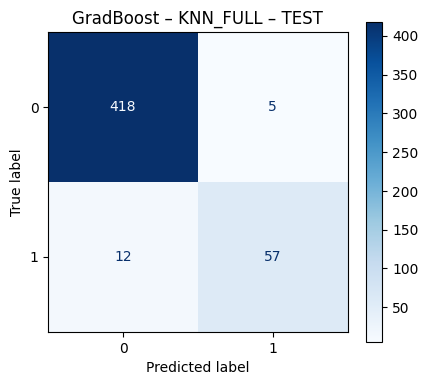


📌 RandForest (knn_full) - F1=0.8710, Précision=0.9818, Rappel=0.7826, AUC=0.9786


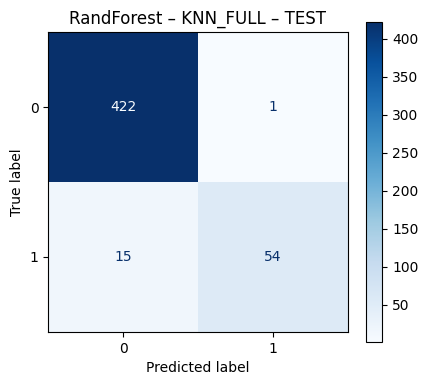


📌 SVM (knn_full) - F1=0.8226, Précision=0.9273, Rappel=0.7391, AUC=0.9463


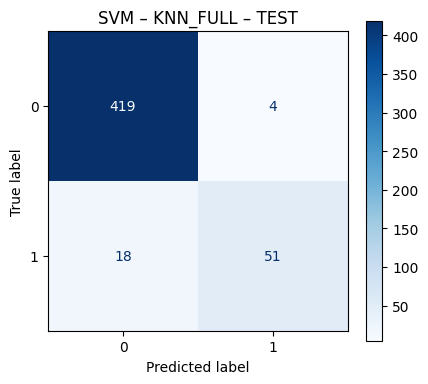


📌 MLP (knn_full) - F1=0.8730, Précision=0.9649, Rappel=0.7971, AUC=0.9732


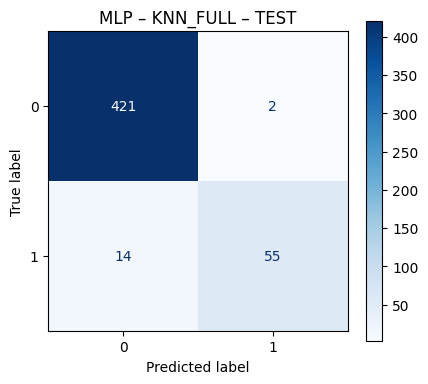


📌 XGBoost (knn_full) - F1=0.8618, Précision=0.9815, Rappel=0.7681, AUC=0.9674


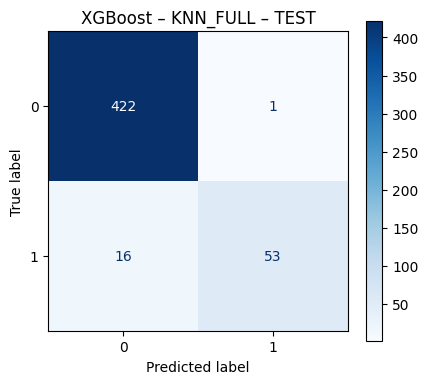


🔍 Évaluation : KNN_REDUCED

📌 GradBoost (knn_reduced) - F1=0.8485, Précision=0.8889, Rappel=0.8116, AUC=0.9568


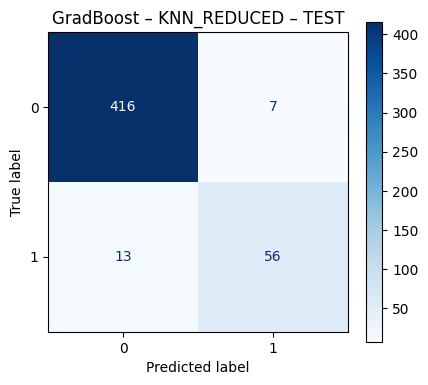


📌 RandForest (knn_reduced) - F1=0.8462, Précision=0.9016, Rappel=0.7971, AUC=0.9728


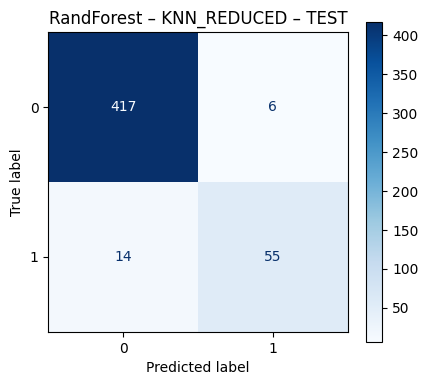


📌 SVM (knn_reduced) - F1=0.9091, Précision=0.9524, Rappel=0.8696, AUC=0.9485


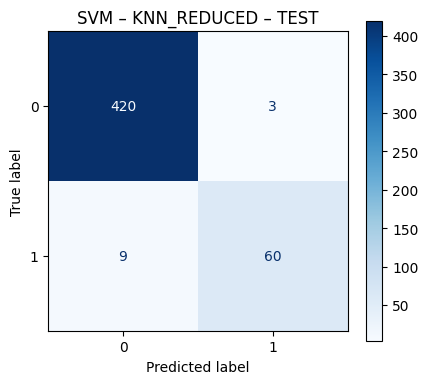


📌 MLP (knn_reduced) - F1=0.8640, Précision=0.9643, Rappel=0.7826, AUC=0.9517


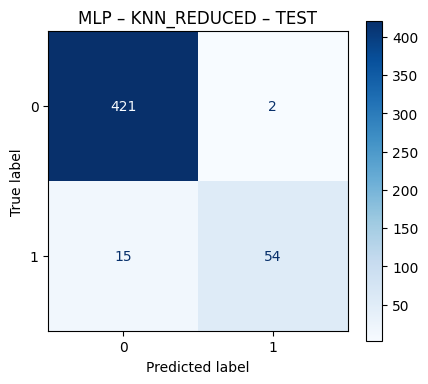


📌 XGBoost (knn_reduced) - F1=0.8618, Précision=0.9815, Rappel=0.7681, AUC=0.9555


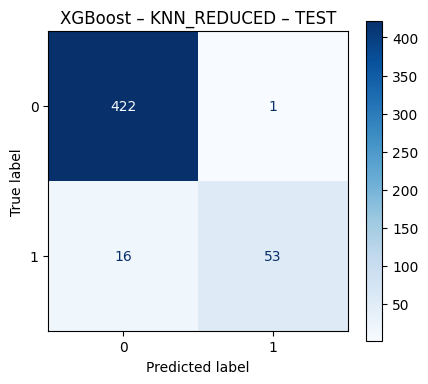


🔍 Évaluation : MICE_FULL

📌 GradBoost (mice_full) - F1=0.8923, Précision=0.9508, Rappel=0.8406, AUC=0.9812


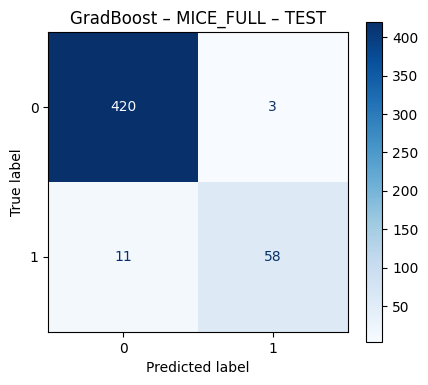


📌 RandForest (mice_full) - F1=0.8992, Précision=0.9667, Rappel=0.8406, AUC=0.9798


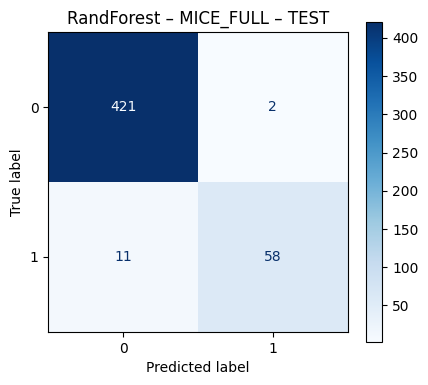


📌 SVM (mice_full) - F1=0.8671, Précision=0.8378, Rappel=0.8986, AUC=0.9604


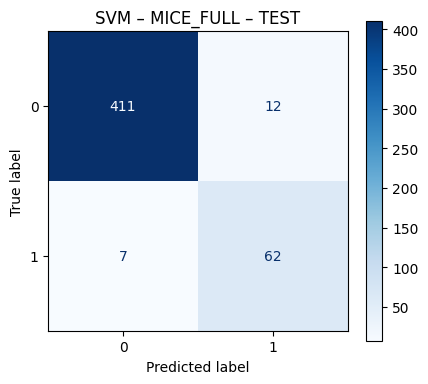


📌 MLP (mice_full) - F1=0.8780, Précision=1.0000, Rappel=0.7826, AUC=0.9677


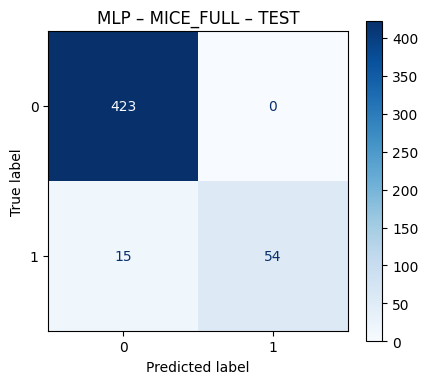


📌 XGBoost (mice_full) - F1=0.8618, Précision=0.9815, Rappel=0.7681, AUC=0.9695


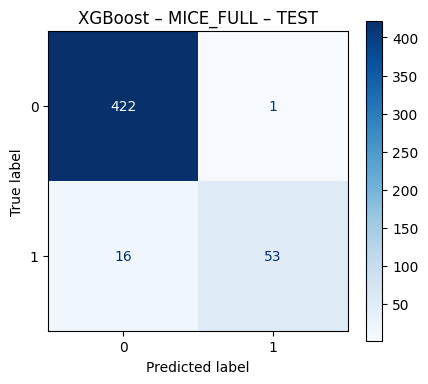


🔍 Évaluation : MICE_REDUCED

📌 GradBoost (mice_reduced) - F1=0.8345, Précision=0.8286, Rappel=0.8406, AUC=0.9587


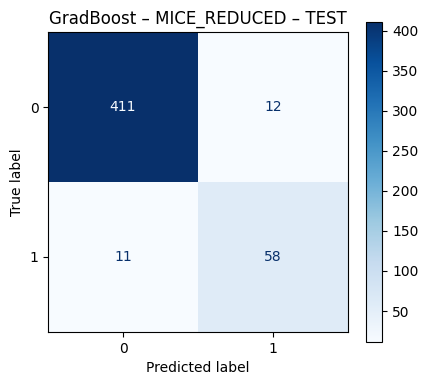


📌 RandForest (mice_reduced) - F1=0.8346, Précision=0.9138, Rappel=0.7681, AUC=0.9612


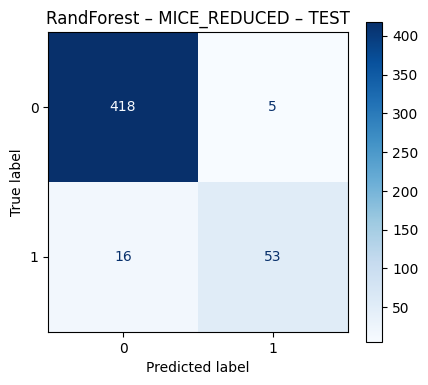


📌 SVM (mice_reduced) - F1=0.8794, Précision=0.8611, Rappel=0.8986, AUC=0.9379


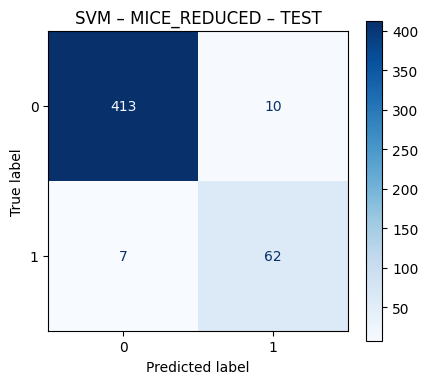


📌 MLP (mice_reduced) - F1=0.8682, Précision=0.9333, Rappel=0.8116, AUC=0.9421


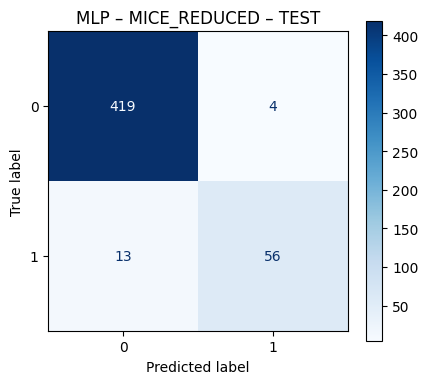


📌 XGBoost (mice_reduced) - F1=0.8413, Précision=0.9298, Rappel=0.7681, AUC=0.9477


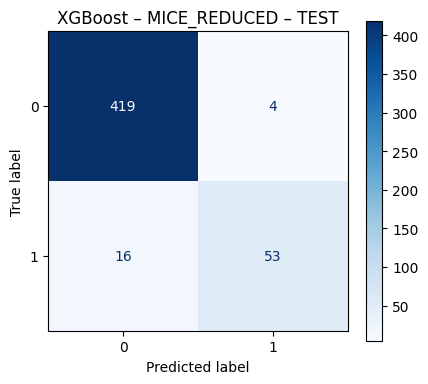


💾 Résultats sauvegardés → test_results_all_models.csv


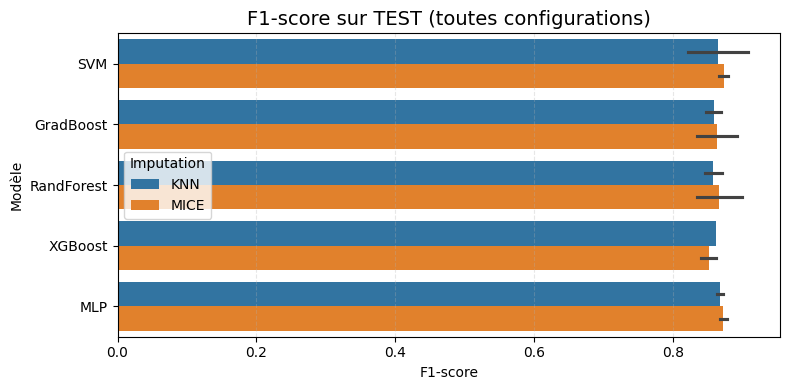

In [45]:
from modeling import (
    evaluate_all_models_on_test,
    load_optimized_thresholds,
    plot_test_performance
)

# Ajout des imports manquants
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Chemins
knn_dir = MODELS_DIR / "knn"
mice_dir = MODELS_DIR / "mice"

# données Complètes
splits_knn = splits["knn"]
splits_mice = splits["mice"]

# Données Réduites
splits_knn_reduced = {
    k: joblib.load(knn_dir / "reduced" / f"knn_{k}_reduced.pkl")
    for k in ["train", "val", "test"]
}
splits_mice_reduced = {
    k: joblib.load(mice_dir / "reduced" / f"mice_{k}_reduced.pkl")
    for k in ["train", "val", "test"]
}

# Génération des dictionnaires
pipelines_dict = {
    "knn_full": best_knn_full_pipes,
    "knn_reduced": best_knn_reduced_pipes,
    "mice_full": best_mice_full_pipes,
    "mice_reduced": best_mice_reduced_pipes,
}

# Correction pour utiliser load_optimized_thresholds
thresholds_dict = {}
for key in ["knn_full", "knn_reduced", "mice_full", "mice_reduced"]:
    imputation, version = key.split("_")
    try:
        df_thresh = load_optimized_thresholds(imputation, version, THRESHOLDS_DIR)
        # Convertir le DataFrame en dictionnaire
        thresholds_dict[key] = {}
        for _, row in df_thresh.iterrows():
            thresholds_dict[key][row["model"]] = {
                "threshold": row["threshold"],
                "f1": row["f1"],
                "precision": row["precision"],
                "recall": row["recall"]
            }
    except Exception as e:
        print(f"Erreur lors du chargement des seuils pour {key}: {e}")

splits_dict = {
    "knn_full": splits["knn"],
    "knn_reduced": splits_knn_reduced,
    "mice_full": splits["mice"],
    "mice_reduced": splits_mice_reduced,
}

# Evaluation globale sur TEST
df_test_results = evaluate_all_models_on_test(
    pipelines_dict, thresholds_dict, splits_dict,
    output_dir=OUTPUTS_DIR / "evaluation_test"
)

# Visualisation manuelle (au lieu d'utiliser plot_test_performance)
if not df_test_results.empty:
    df_sorted = df_test_results.sort_values("f1", ascending=True)
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(data=df_sorted, x="f1", y="model", hue="imputation", dodge=True)
    plt.title("F1-score sur TEST (toutes configurations)", fontsize=14)
    plt.xlabel("F1-score")
    plt.ylabel("Modèle")
    plt.grid(axis="x", alpha=0.3, linestyle="--")
    plt.legend(title="Imputation")
    plt.tight_layout()
    plt.show()
else:
    print("Données vides. Rien à afficher.")

2025-08-09 22:14:53,380 - INFO - Attempting to get split for key: knn_full
2025-08-09 22:14:53,381 - INFO - Split dictionary for key knn_full: dict_keys(['val'])
2025-08-09 22:14:53,382 - INFO - Accessing 'val' key. Contains: dict_keys(['X', 'y'])
2025-08-09 22:14:53,465 - INFO - Attempting to get split for key: knn_reduced
2025-08-09 22:14:53,465 - INFO - Split dictionary for key knn_reduced: dict_keys(['val'])
2025-08-09 22:14:53,467 - INFO - Accessing 'val' key. Contains: dict_keys(['X', 'y'])
2025-08-09 22:14:53,507 - INFO - Attempting to get split for key: mice_full
2025-08-09 22:14:53,507 - INFO - Split dictionary for key mice_full: dict_keys(['val'])
2025-08-09 22:14:53,510 - INFO - Accessing 'val' key. Contains: dict_keys(['X', 'y'])
2025-08-09 22:14:53,575 - INFO - Attempting to get split for key: mice_reduced
2025-08-09 22:14:53,575 - INFO - Split dictionary for key mice_reduced: dict_keys(['val'])
2025-08-09 22:14:53,575 - INFO - Accessing 'val' key. Contains: dict_keys(['X'

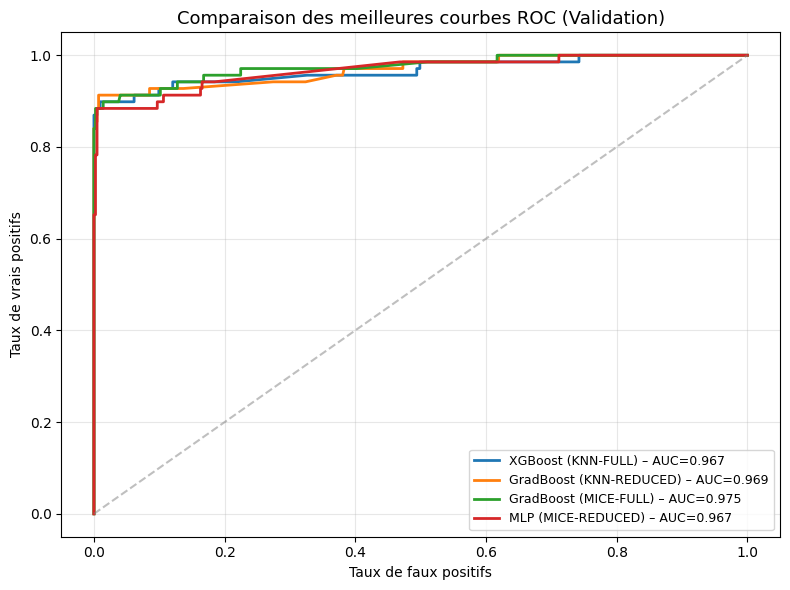

In [ ]:
# Comparaison des Courbes ROC (via module)
from modeling import plot_best_roc_curves_comparison
from sklearn.metrics import roc_curve, auc

# Patcher le module avec les imports manquants
import modules.modeling as modeling_module
modeling_module.roc_curve = roc_curve
modeling_module.auc = auc

# Définir les chemins principaux
MODELS_DIR_ROC = MODELS_DIR
FIGURES_NB2_DIR_ROC = FIGURES_NB2_DIR / "final_comparison"

# Construction du dictionnaire des splits avec validation uniquement
all_splits = {
    "knn_full": {"val": {"X": splits["knn"]["X_val"], "y": splits["knn"]["y_val"]}},
    "knn_reduced": {"val": {"X": splits_knn_reduced["val"]["X"], "y": splits_knn_reduced["val"]["y"]}},
    "mice_full": {"val": {"X": splits["mice"]["X_val"], "y": splits["mice"]["y_val"]}},
    "mice_reduced": {"val": {"X": splits_mice_reduced["val"]["X"], "y": splits_mice_reduced["val"]["y"]}},
}

plot_best_roc_curves_comparison(
    models_dir=MODELS_DIR_ROC,
    FIGURES_NB2_DIR=FIGURES_NB2_DIR_ROC,
    splits=all_splits
)

# Conclusion - Notebook 2

## Objectifs atteints dans ce notebook :

- Comparaison des imputations : Impact des méthodes **KNN** et **MICE** sur les performances
- Portefeuille de modèles : Gradient Boosting, Random Forest, SVM, MLP, XGBoost optimisés via `GridSearchCV` (10 plis)
- Gestion du déséquilibre : BorderlineSMOTE pour équilibrer les classes
- Optimisation des seuils : Maximisation du F1-score sur validation
- Évaluation finale : Test sur jeu de test pour mesurer la généralisation
- Sauvegarde complète : Pipelines et seuils optimaux pour stacking

## Résultats Clés :

### **Modèle Champion (Validation avec seuils optimisés)**
- **Gradient Boosting KNN REDUCED** : F1 = **0.9333**, Seuil = 0.285
- **Précision** : 0.9545, **Rappel** : 0.9130
- Bonne généralisation confirmée sur test

### **Performances sur Test (Top 5)**

| Modèle | Imputation | Version | F1-Test | Précision | Rappel |
|--------|------------|---------|----------|-----------|--------|
| **SVM** | KNN | REDUCED | **0.9091** | 0.9524 | 0.8696 |
| **RandForest** | MICE | FULL | 0.8992 | 0.9667 | 0.8406 |
| **GradBoost** | MICE | FULL | 0.8923 | 0.9508 | 0.8406 |
| **SVM** | MICE | REDUCED | 0.8794 | 0.8611 | 0.8986 |
| **MLP** | MICE | FULL | 0.8780 | 1.0000 | 0.7826 |

### **Champion Validation vs Test**
- **Champion Validation** : GradBoost KNN REDUCED (F1=0.9333)
- **Champion Test** : SVM KNN REDUCED (F1=0.9091)
- **Gap validation/test** : 0.0242 (excellente généralisation)

### **Insights Importants**
- **Optimisation des seuils cruciale** : Amélioration majeure par rapport au seuil par défaut (0.5)
- **KNN REDUCED surprenant** : La version réduite surpasse souvent la version complète
- **SVM robuste** : Meilleures performances sur test malgré scores validation plus faibles
- **Excellente généralisation** : Gaps validation/test faibles pour tous les modèles
- **Données réduites compétitives** : Performance proche des versions complètes avec moins de variables

## Artefacts Prêts pour Stacking :
- `pipeline_[modele]_[imputation]_[version].joblib`
- `threshold_[modele]_[imputation]_[version].json`
- `df_all_thresholds.csv` (synthèse complète)
- Champion final sauvegardé : `pipeline_gradboost_knn_reduced_champion.joblib`

## Prochaine Étape : Stacking (Notebook 03)
Combinaison des modèles de base pour créer un ensemble plus puissant via méta-modèle.

**Objectif** : Dépasser le F1-score de 0.9333 (validation) et 0.9091 (test) grâce au stacking.